In [1]:
from utils import load_dtrajs_from_npz
raw_dtrajs_abl = load_dtrajs_from_npz('dtrajs/abl_11400_2000_dtrajs.npz')

# trim dtrajs when building MSM
def trim_dtrajs(dtrajs,length_to_discard=10,min_length=100):
    trimmed = [traj[length_to_discard:] for traj in dtrajs if len(traj)>length_to_discard]
    return trimmed

dtrajs_abl = trim_dtrajs(raw_dtrajs_abl)

# build MSM
import msmbuilder.msm
lag_frames = 40
ergodic_cutoff_in_frames=20
ergodic_cutoff = 1.0*ergodic_cutoff_in_frames/lag_frames
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())
M = mb_msm_abl

MSM contains 1430 strongly connected components above weight=0.50. Component 178 selected, with population 72.095405%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 338
Number of nonzero entries in counts matrix : 6216 (5.44098595988%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.1
    Mean   : 2.2
    3rd Qu.: 0.5
    Max.   : 1487.5

Total transition counts :
    13631.35 counts
Total transition counts / lag_time:
    340.78375 units
Timescales:
    [2169.54, 1907.65, 1858.34, 1800.73, 1659.07, 1590.01, 1542.29, 1477.60, 1345.10, 1332.19, 1191.67, 1156.80, 1068.17, 982.33, 933.27, 815.23, 752.10, 700.40, 695.71, 647.44, 637.63, 629.52, 600.83, 540.80, 534.18, 532.25, 529.38, 506.88, 501.71, 420.72, 402.92, 399.72, 398.36, 386.80, 382.91, 381.67, 379.46, 372.06, 366.12, 364.78, 362.00, 356.31, 339.54, 328.00, 324.58, 324.00, 315.33, 300.18, 295.68, 285

In [182]:
import numpy as np

def flat_probs_from_msm(flat_labels,M,n_micro=2000):

    # probability per snapshot = microstate_probability/nsamples_in_microstate
    label_probabilities = np.zeros(n_micro)
    for label in M.mapping_:
        nsamples_per_label = np.sum(flat_labels==label)
        pi_label = M.populations_[M.mapping_[label]]
        label_probabilities[label] = pi_label / nsamples_per_label
    flat_probs = np.array([label_probabilities[i] for i in flat_labels])
    
    return flat_probs

# flatten labels
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,M,n_micro=len(set(flat_labels)))

# define reducing function to color each bin: 
# free energy of a bin = -\ln (\sum_snapshots probability(snapshot))
reducing_function = lambda x:-np.log(np.sum(x))

# get locations
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

In [221]:
import matplotlib.pyplot as plt
plt.rc('font', family='sans-serif')
%matplotlib inline

In [222]:
_np = np
_plt = plt
# stolen and modified from: https://github.com/markovmodel/PyEMMA/blob/devel/pyemma/plots/plots2d.py#L96-L149
def mod_plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, offset=0.1,
                     cmap='spectral', cbar=True, cbar_label='Free energy (kT)'):
    """Free energy plot given 2D scattered data
    Builds a 2D-histogram of the given data points and plots -log(p) where p is
    the probability computed from the histogram count.
    Parameters
    ----------
    xall : ndarray(T)
        sample x-coordinates
    yall : ndarray(T)
        sample y-coordinates
    weights : ndarray(T), default = None
        sample weights. By default all samples have the same weight
    ax : matplotlib Axes object, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    nbins : int, default=100
        number of histogram bins used in each dimension
    offset : float, default=0.1
        small additive shift to the histogram. This creates a small bias to the
        distribution, but gives a better visual impression with the default
        colormap.
    cmap : matplotlib colormap, optional, default = None
        the color map to use. None will use pylab.cm.spectral.
    cbar : boolean, default=True
        plot a color bar
    cbar_label : str or None, default='Free energy (kT)'
        colorbar label string. Use None to suppress it.
    Returns
    -------
    ax : Axes object containing the plot
    fig : Figure object containing the plot
    """
    import matplotlib.pylab as _plt

    z, x, y = _np.histogram2d(xall, yall, bins=nbins, weights=weights)
    z += offset
    # compute free energies
    F = -_np.log(z)
    
    # subtract minimum!
    F -= F.min()
    
    
    # do a contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    if ax is None:
        ax = _plt.gca()
    CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap,
                     #hatches=True,
                    )
    #ax.contour(F.T)
    
    if cbar:
        cbar = _plt.colorbar(CS)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax, _plt.gcf()

In [223]:
help(plt.hexbin)

Help on function hexbin in module matplotlib.pyplot:

hexbin(x, y, C=None, gridsize=100, bins=None, xscale=u'linear', yscale=u'linear', extent=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=u'none', reduce_C_function=<function mean>, mincnt=None, marginals=False, hold=None, data=None, **kwargs)
    Make a hexagonal binning plot.
    
    Call signature::
    
       hexbin(x, y, C = None, gridsize = 100, bins = None,
              xscale = 'linear', yscale = 'linear',
              cmap=None, norm=None, vmin=None, vmax=None,
              alpha=None, linewidths=None, edgecolors='none'
              reduce_C_function = np.mean, mincnt=None, marginals=True
              **kwargs)
    
    Make a hexagonal binning plot of *x* versus *y*, where *x*,
    *y* are 1-D sequences of the same length, *N*. If *C* is *None*
    (the default), this is a histogram of the number of occurences
    of the observations at (x[i],y[i]).
    
    If *C* is specifi

In [224]:
# define reducing function to color each bin: 
# free energy of a bin = -\ln (\sum_snapshots probability(snapshot))
reducing_function = lambda x:-np.log(np.sum(x)+0.00001)-5.8
# note I added a small offset to prevent the log from blowing up

# maybe I can get away with using an if clause instead
#def reducing_function_(x):
#    s = np.sum(x)
#    if s==0:
#        return 0
#    else:
#        return -np.log(s)
    
# nope that looks awful as well, reverting to a small offset

In [225]:
# hacky but I'm not sure how else to subtract the minimum value from the hex-bin plots
minimum_last_run=np.inf
def reducing_function(x,offset=0.00001):
    raw = -np.log(np.sum(x)+offset)
    global minimum_last_run
    minimum_last_run = min(raw,minimum_last_run)
    return raw - minimum_last_run

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


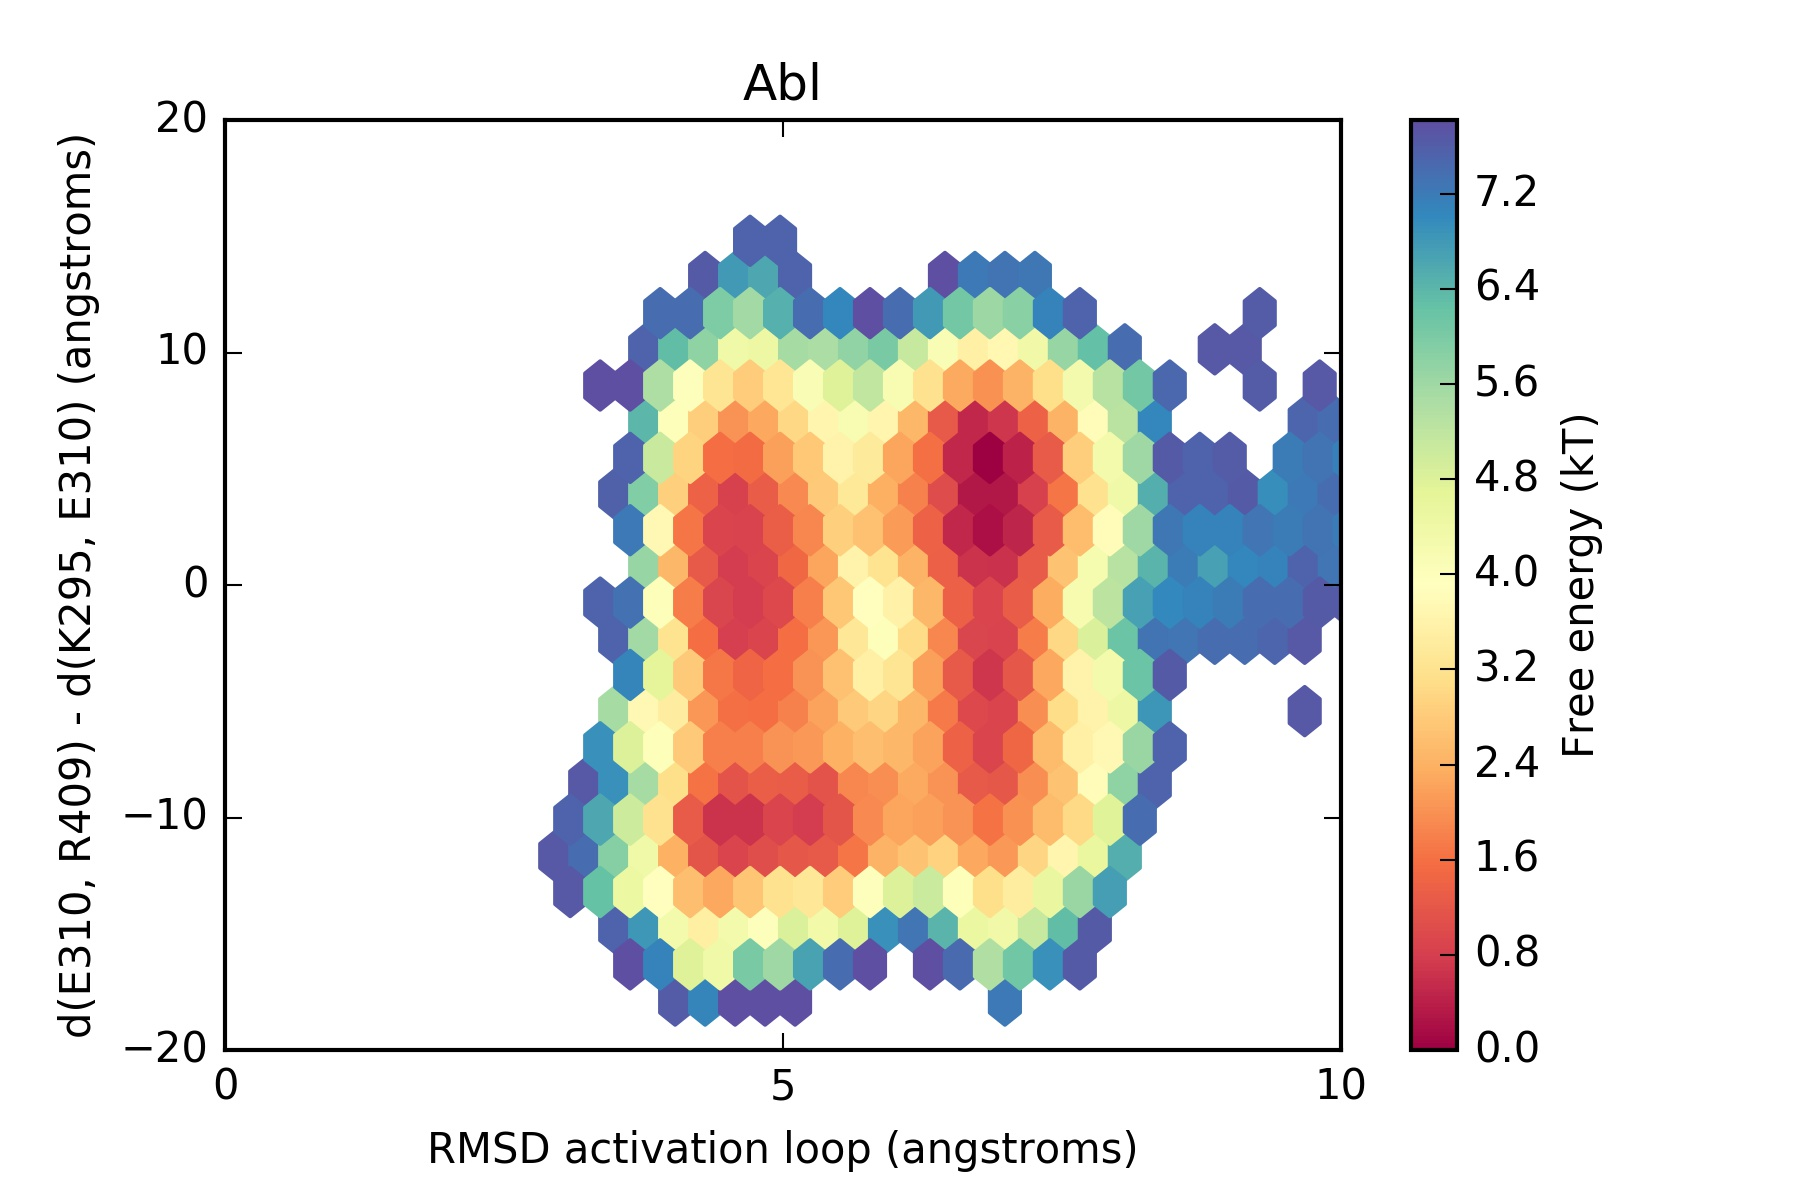

In [226]:
import pyemma
from IPython.display import Image


def shukla_plot_pe(X1,X2,flat_probs,title='Abl',bins=100):

    ax = plt.gca()
    ax.set_xlim(0,10)
    ax.set_ylim(-20,20)
    ax.set_xticks([0,5,10])
    ax.set_yticks([-20,-10,0,10,20])

    mod_plot_free_energy(X1,X2,flat_probs,ax,offset=0,nbins=bins,
                         #cmap='BuGn_r',
                         #cmap='Spectral_r',
                         #cmap='spectral_r',
                         cmap='Spectral'
                        )

    plt.xlabel('RMSD activation loop (angstroms)')
    plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
    plt.title(title)
    plt.savefig('{0}_free_energy_landscape_pe.jpg'.format(title),dpi=300)
    
    
    return ax

  
def shukla_plot_hex(X1,X2,flat_probs,title='Abl',bins=100):
    global minimum_last_run
    minimum_last_run=np.inf
    for i in range(2):
        plt.close()
        cbar_label='Free energy (kT)'
        ax = plt.gca()
        ax.set_xlim(0,10)
        ax.set_ylim(-20,20)
        ax.set_xticks([0,5,10])
        ax.set_yticks([-20,-10,0,10,20])

        cs = plt.hexbin(X1,X2,C=flat_probs,
                   gridsize=bins,
                   cmap='Spectral',
                   reduce_C_function=reducing_function,
                   #reduce_C_function=np.sum

                  )
        plt.xlabel('RMSD activation loop (angstroms)')
        plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
        plt.title(title)
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel(cbar_label)


        # plt.colorbar()
    
    
    plt.savefig('{0}_free_energy_landscape_hex.jpg'.format(title),dpi=300)
    
bins=36
shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()

Image('Abl_free_energy_landscape_hex.jpg',retina=True)

In [227]:
minimum_last_run

3.6925275415180674

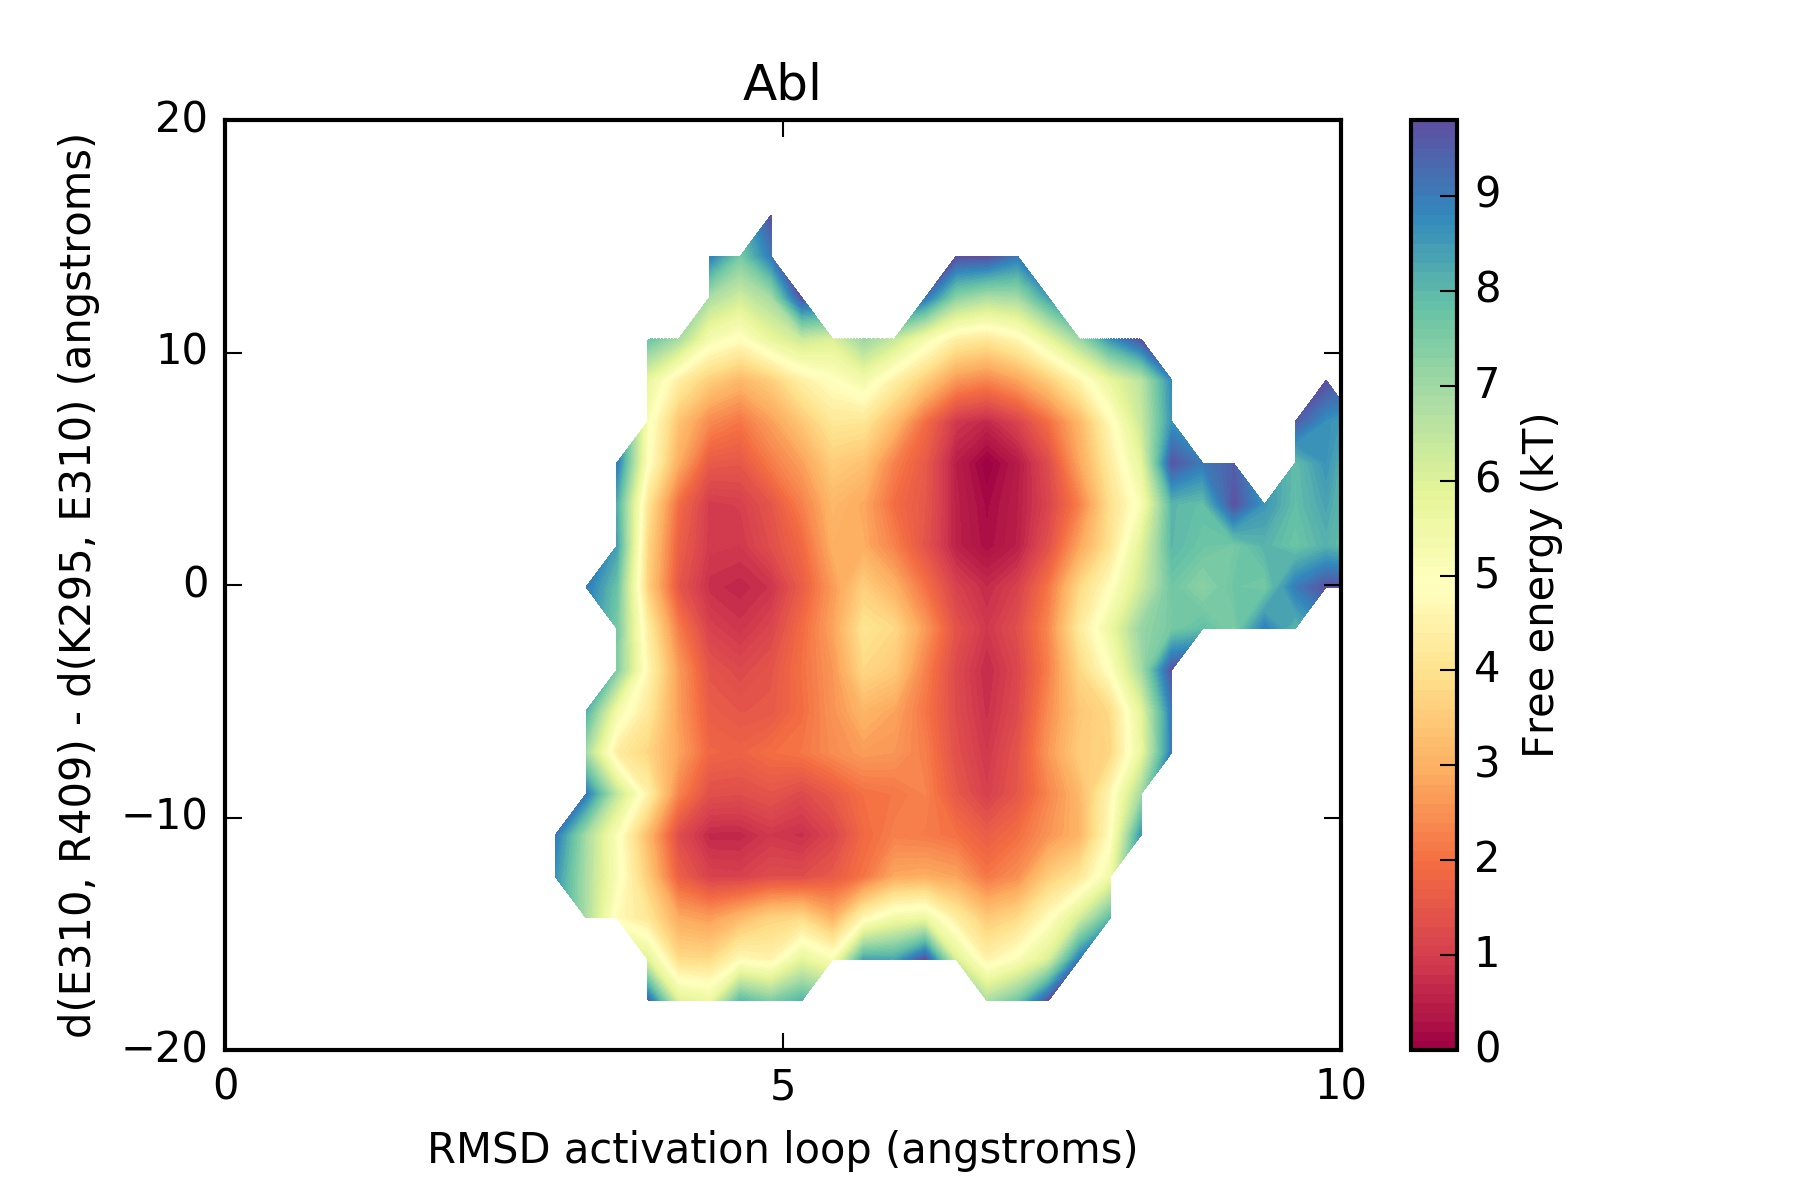

In [229]:
Image('Abl_free_energy_landscape_pe.jpg',retina=True)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


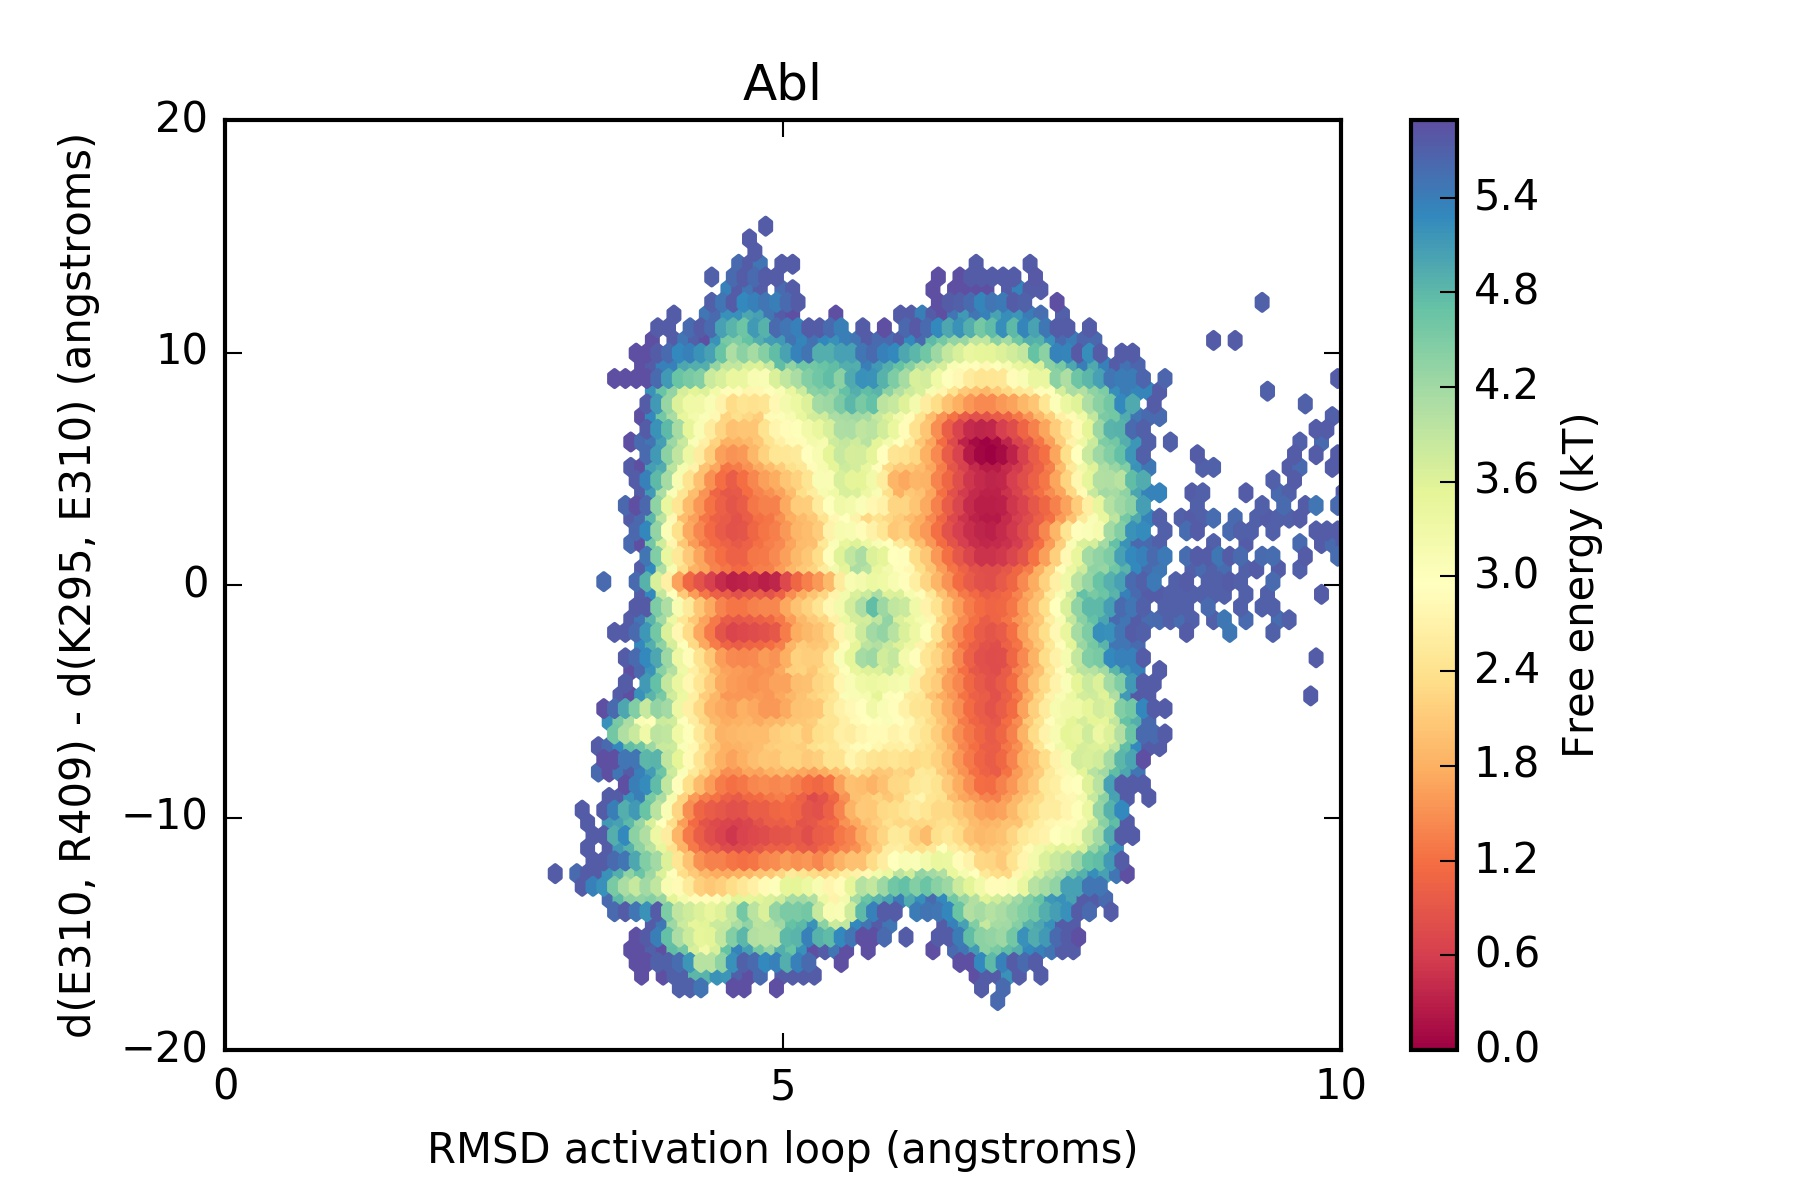

In [230]:
bins=100

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()

Image('Abl_free_energy_landscape_hex.jpg',retina=True)

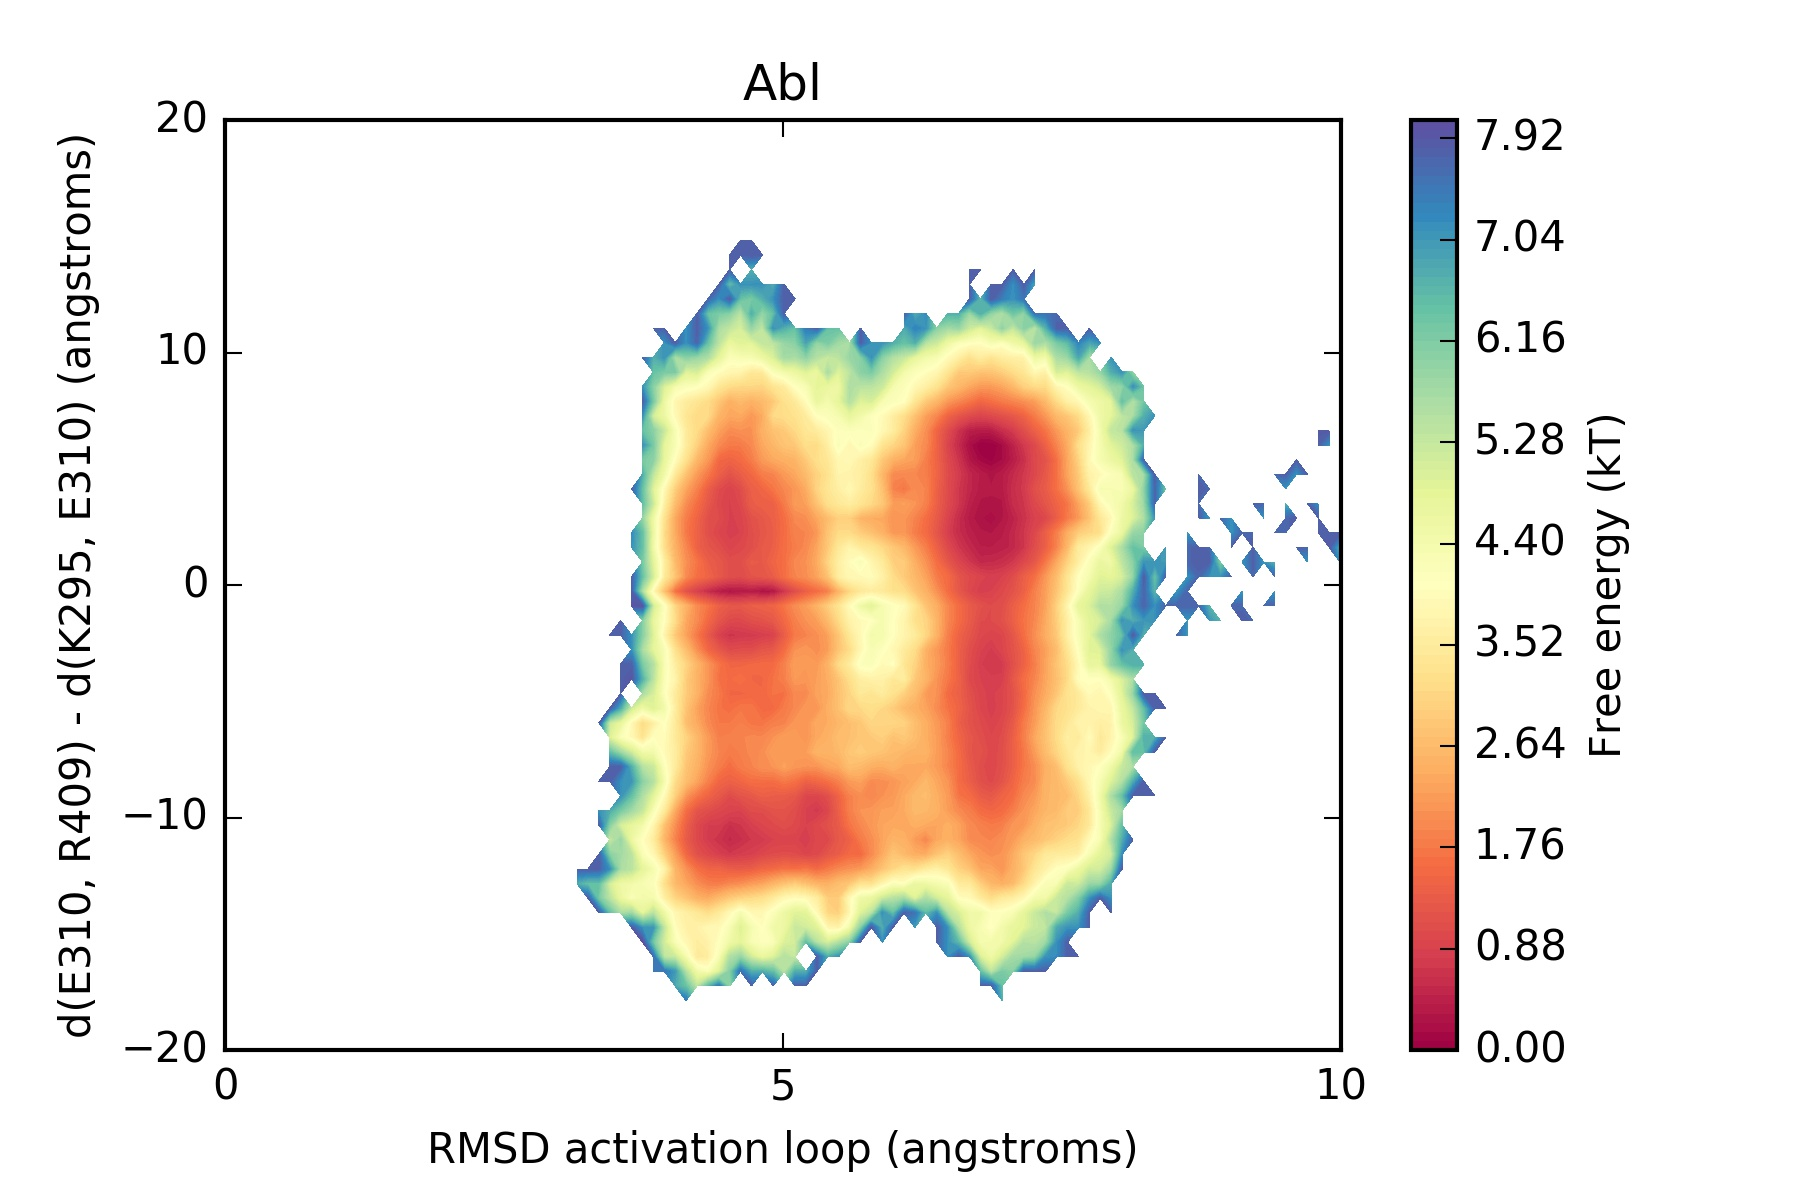

In [231]:
Image('Abl_free_energy_landscape_pe.jpg',retina=True)

In [232]:
# # without weights
# shukla_plot(X1,X2,np.ones(len(X1)),'Abl_flat')
# Image('Abl_flat_free_energy_landscape.jpg',retina=True)

MSM contains 1789 strongly connected components above weight=0.50. Component 49 selected, with population 23.611457%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 52
Number of nonzero entries in counts matrix : 1153 (42.6405325444%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 0.9
    3rd Qu.: 0.7
    Max.   : 61.7

Total transition counts :
    991.9 counts
Total transition counts / lag_time:
    24.7975 units
Timescales:
    [2308.10, 1141.29, 346.74, 293.34, 258.27, 200.46, 168.38, 152.31, 97.69, 92.18, 55.69, 52.05, 47.25, 40.30, 36.65, 36.12, 34.67, 34.10, 33.49, 32.46, 31.89, 30.82, 29.98, 29.23, 28.68, 27.99, 27.18, 26.23, 25.63, 24.72, 24.21, 23.79, 23.23, 22.49, 22.08, 21.65, 21.46, 21.01, 20.38, 19.89, 19.03, 18.70, 16.98, 15.40, 15.14, 14.36, 12.20, nan, nan, nan, nan]  units



/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


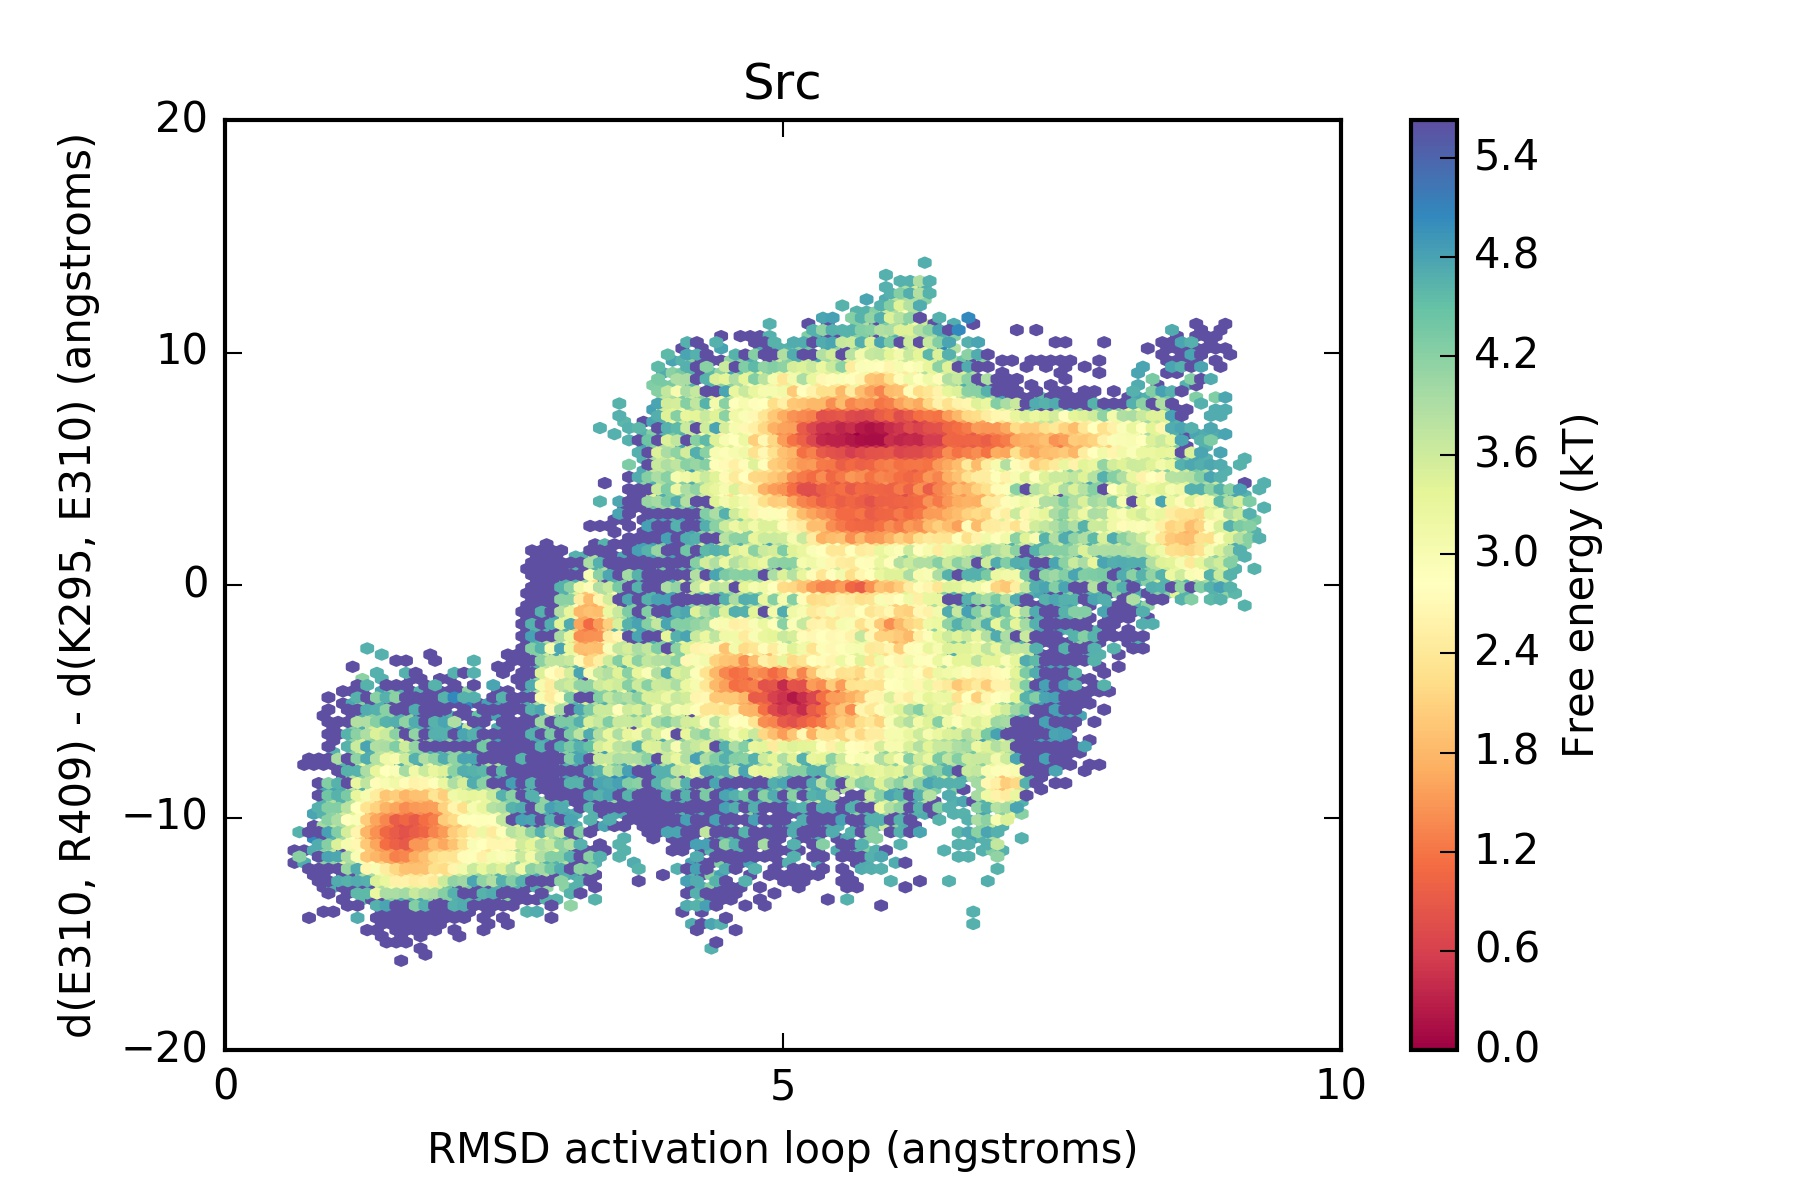

In [233]:
# now redo it for src!
bins=100

raw_dtrajs_src = load_dtrajs_from_npz('dtrajs/src_11401_2000_dtrajs.npz')
dtrajs_src = trim_dtrajs(raw_dtrajs_src)

mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Src',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Src',bins=bins)
plt.close()

Image('Src_free_energy_landscape_hex.jpg',retina=True)

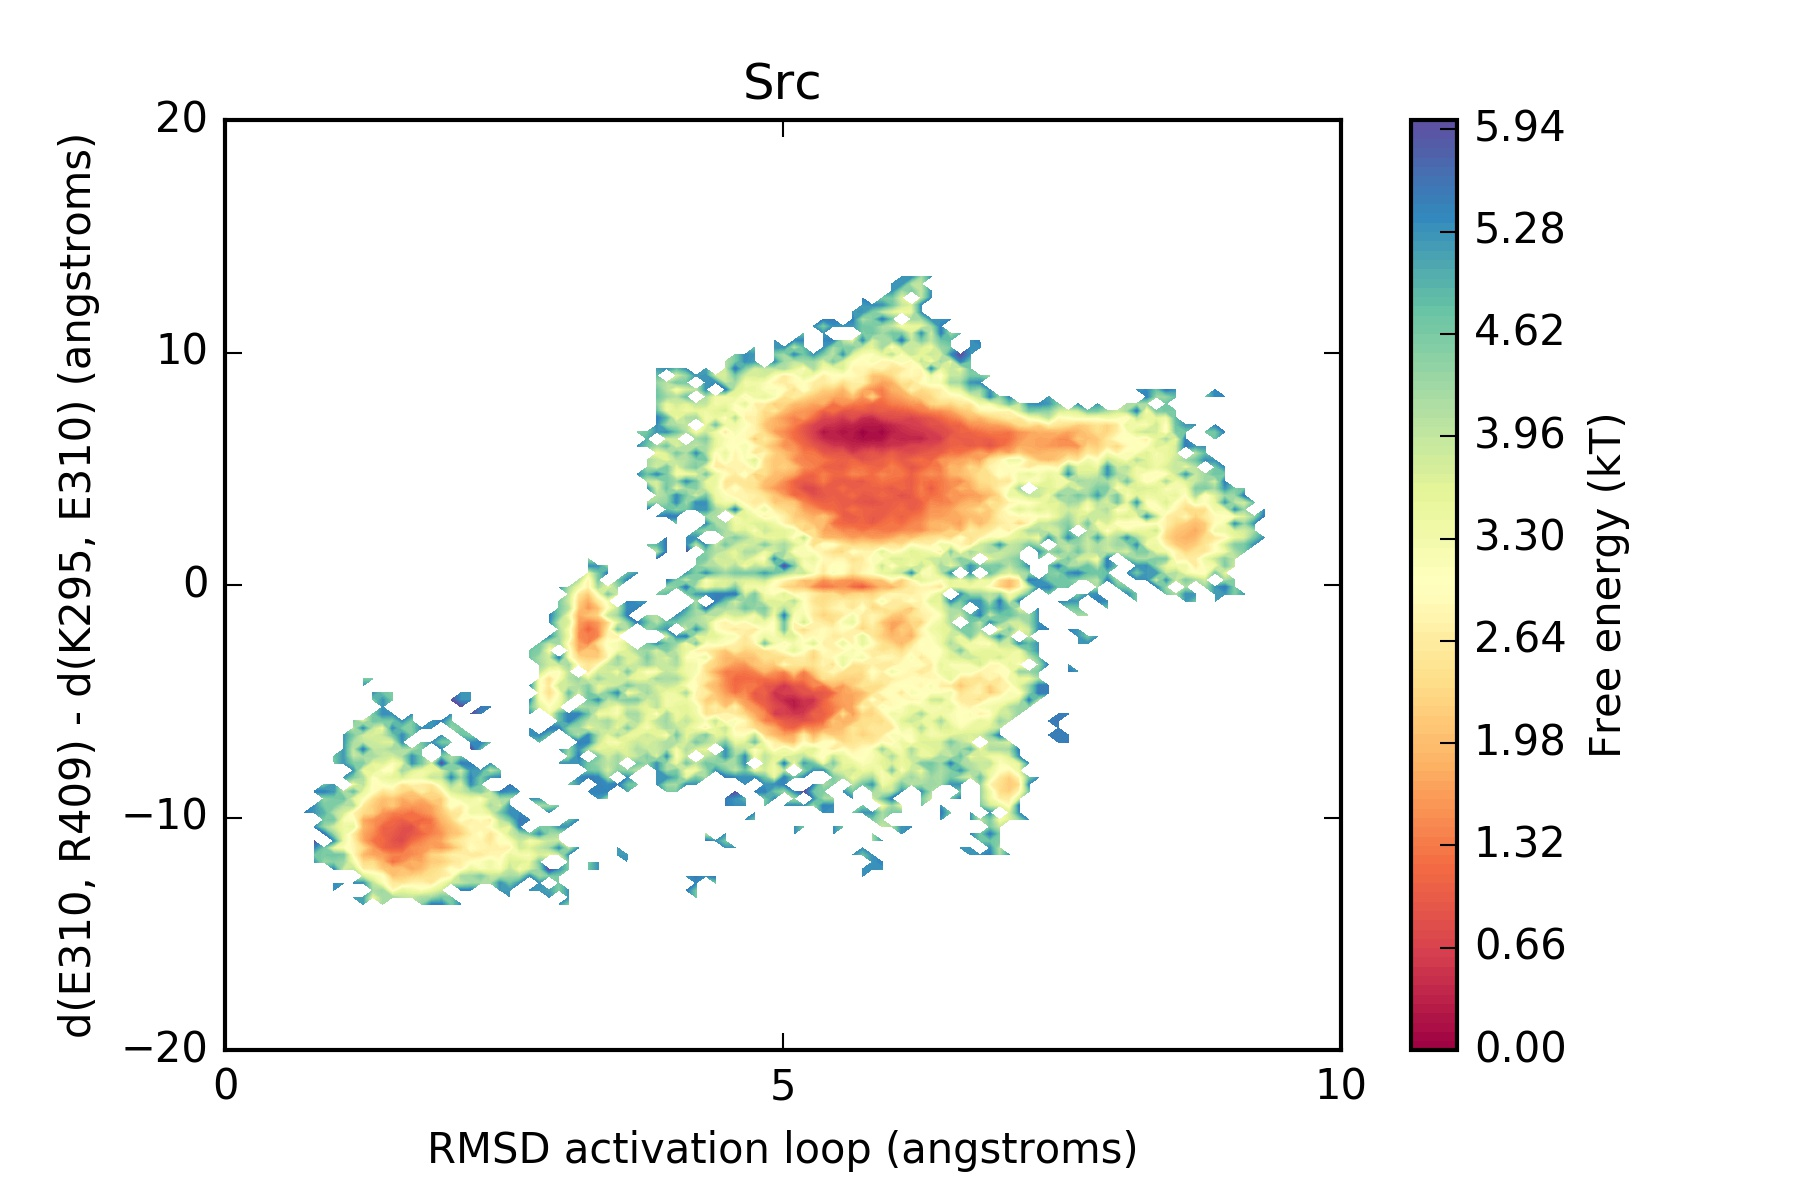

In [234]:
Image('Src_free_energy_landscape_pe.jpg',retina=True)

In [235]:
# now getting k-medoid representative locations
def get_flat_inds(model='abl'):
    if model=='abl':
        kmeds_f = 'abl_11400_2000_kmeds.pickle'
        dtrajs_f = 'dtrajs/abl_11400_2000_dtrajs.npz'
        dtrajs = raw_dtrajs_abl
    elif model=='src':
        kmeds_f = 'src_11401_2000_kmeds.pickle'
        dtrajs_f = 'dtrajs/src_11401_2000_dtrajs.npz'
        dtrajs = raw_dtrajs_src
    
    # load kmeds cluster model
    import cPickle
    f = open(kmeds_f,'r')
    kmeds = cPickle.load(f)
    f.close()

    # find mapping between trajectory id's in 
    from utils import find_one_step_mapping
    traj_mapping = find_one_step_mapping(dtrajs_f)
    inv_traj_map_dict = {v:k for k,v in traj_mapping.items()}
    def traj_frame_pair_to_flat_index(traj,frame,raw_dtrajs):
        ''' flat index = sum (lengths of all preceding trajs) + the frame
        number within current traj'''

        lens = [len(dtraj) for dtraj in raw_dtrajs]
        return sum(lens[:traj]) + frame

    # convert each cluster's traj,frame pair to a flat index
    flat_inds = []
    for traj,frame in kmeds.cluster_ids_:
        flat_inds.append(traj_frame_pair_to_flat_index(inv_traj_map_dict[traj],frame,dtrajs))
    flat_inds = np.array(flat_inds)
    return flat_inds

In [236]:
flat_inds_abl = get_flat_inds('abl')
flat_inds_src = get_flat_inds('src')

In [237]:
macrostate_ids_abl = np.load('macrostate_ids_abl.npy')

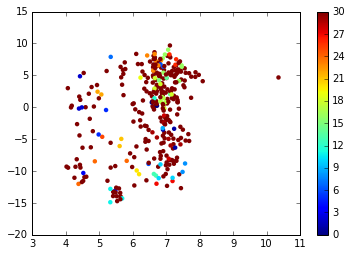

In [238]:
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

plt.scatter(X1[flat_inds_abl][macrostate_ids_abl!=-1],
            X2[flat_inds_abl][macrostate_ids_abl!=-1],
            c=macrostate_ids_abl[macrostate_ids_abl!=-1],
           linewidths=0)
plt.colorbar()

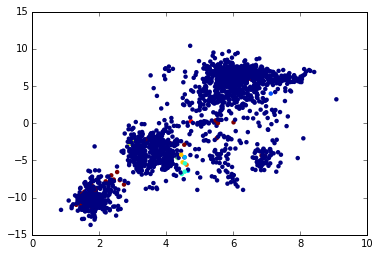

In [249]:
macrostate_ids_src = np.load('macrostate_ids_src.npy')

X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

plt.scatter(X1[flat_inds_src],X2[flat_inds_src],c=macrostate_ids_src,
           linewidths=0)

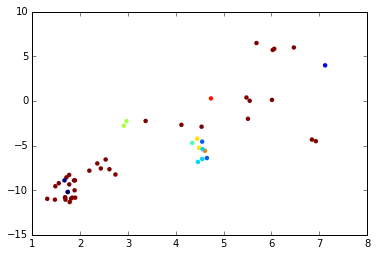

In [250]:
plt.scatter(X1[flat_inds_src][macrostate_ids_src!=-1],
            X2[flat_inds_src][macrostate_ids_src!=-1],
            c=macrostate_ids_src[macrostate_ids_src!=-1],
           linewidths=0)

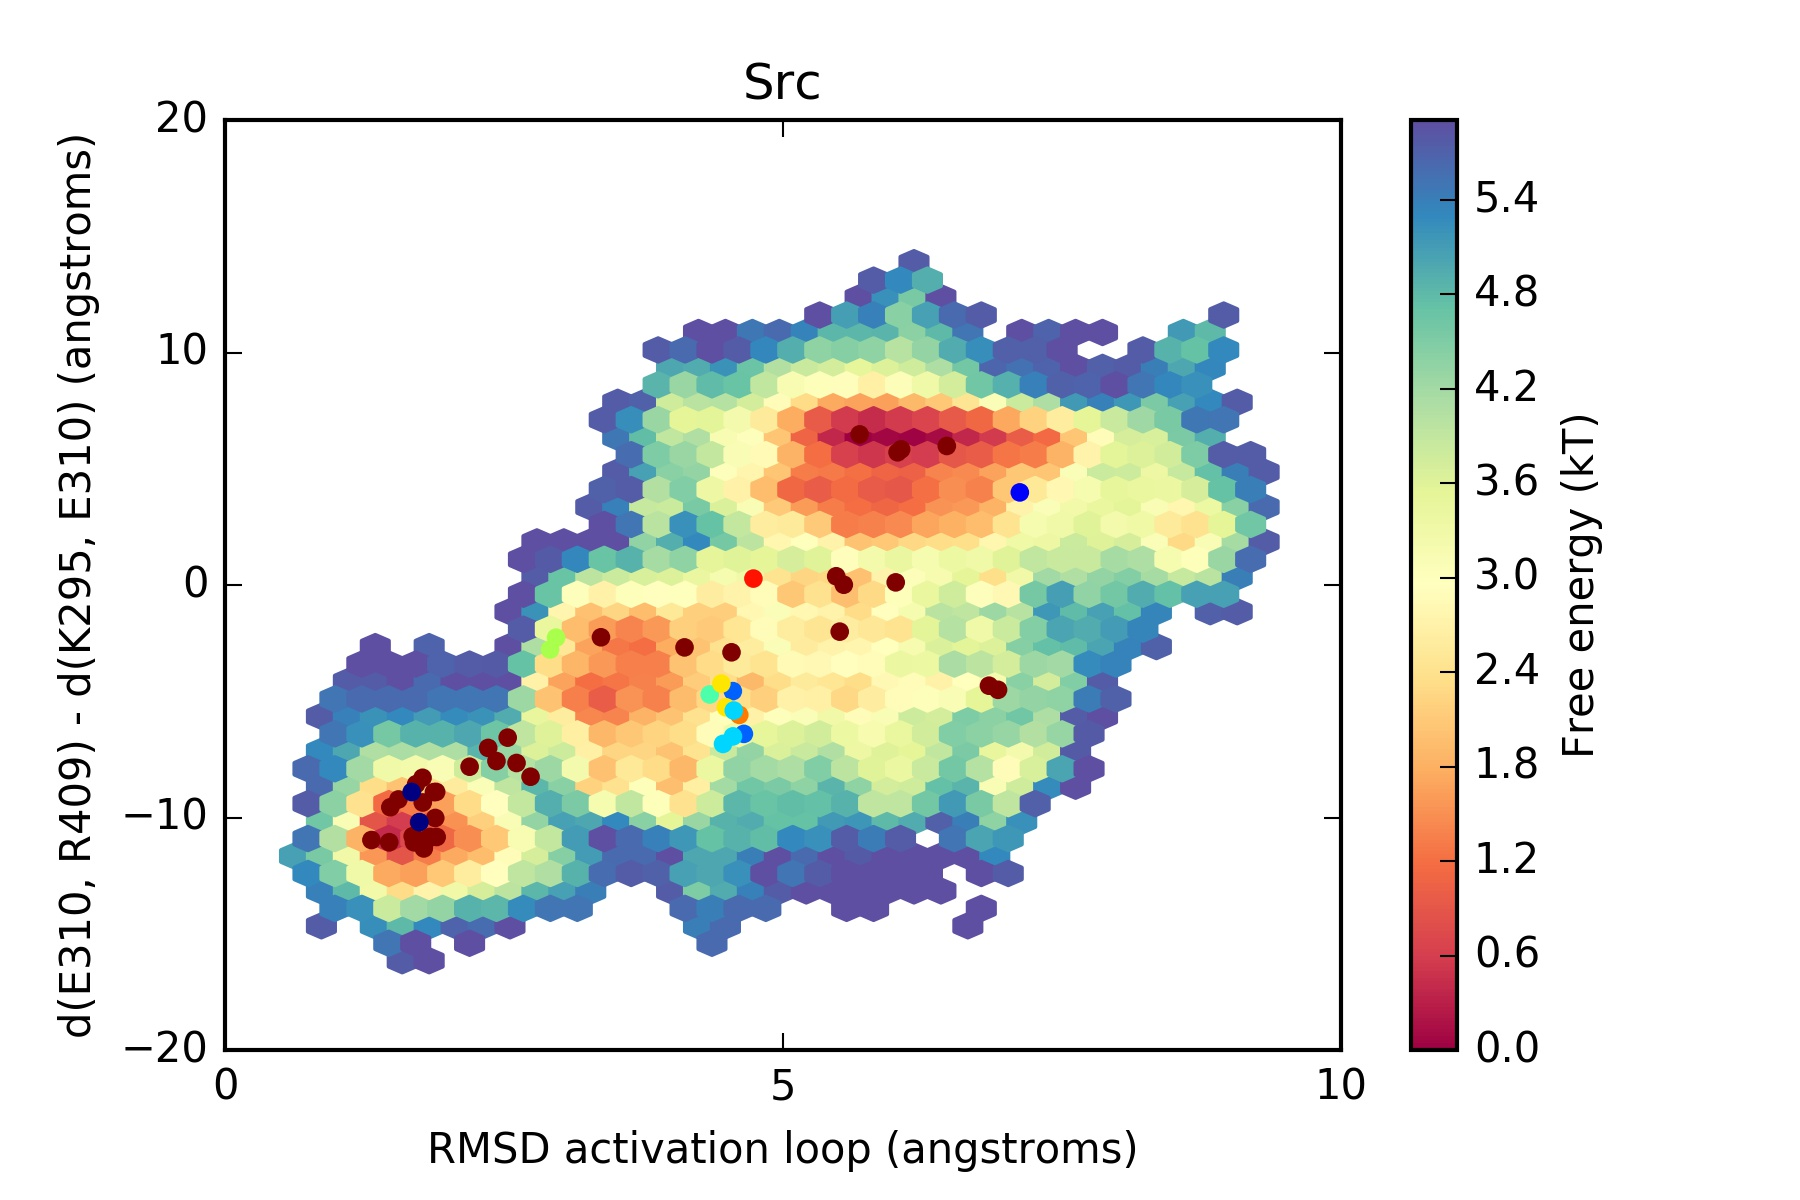

In [251]:
bins=36
shukla_plot_hex(X1,X2,flat_probs,'Src',bins=bins)
plt.scatter(X1[flat_inds_src][macrostate_ids_src!=-1],
            X2[flat_inds_src][macrostate_ids_src!=-1],
            c=macrostate_ids_src[macrostate_ids_src!=-1],
           linewidths=0)
name = 'Src_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

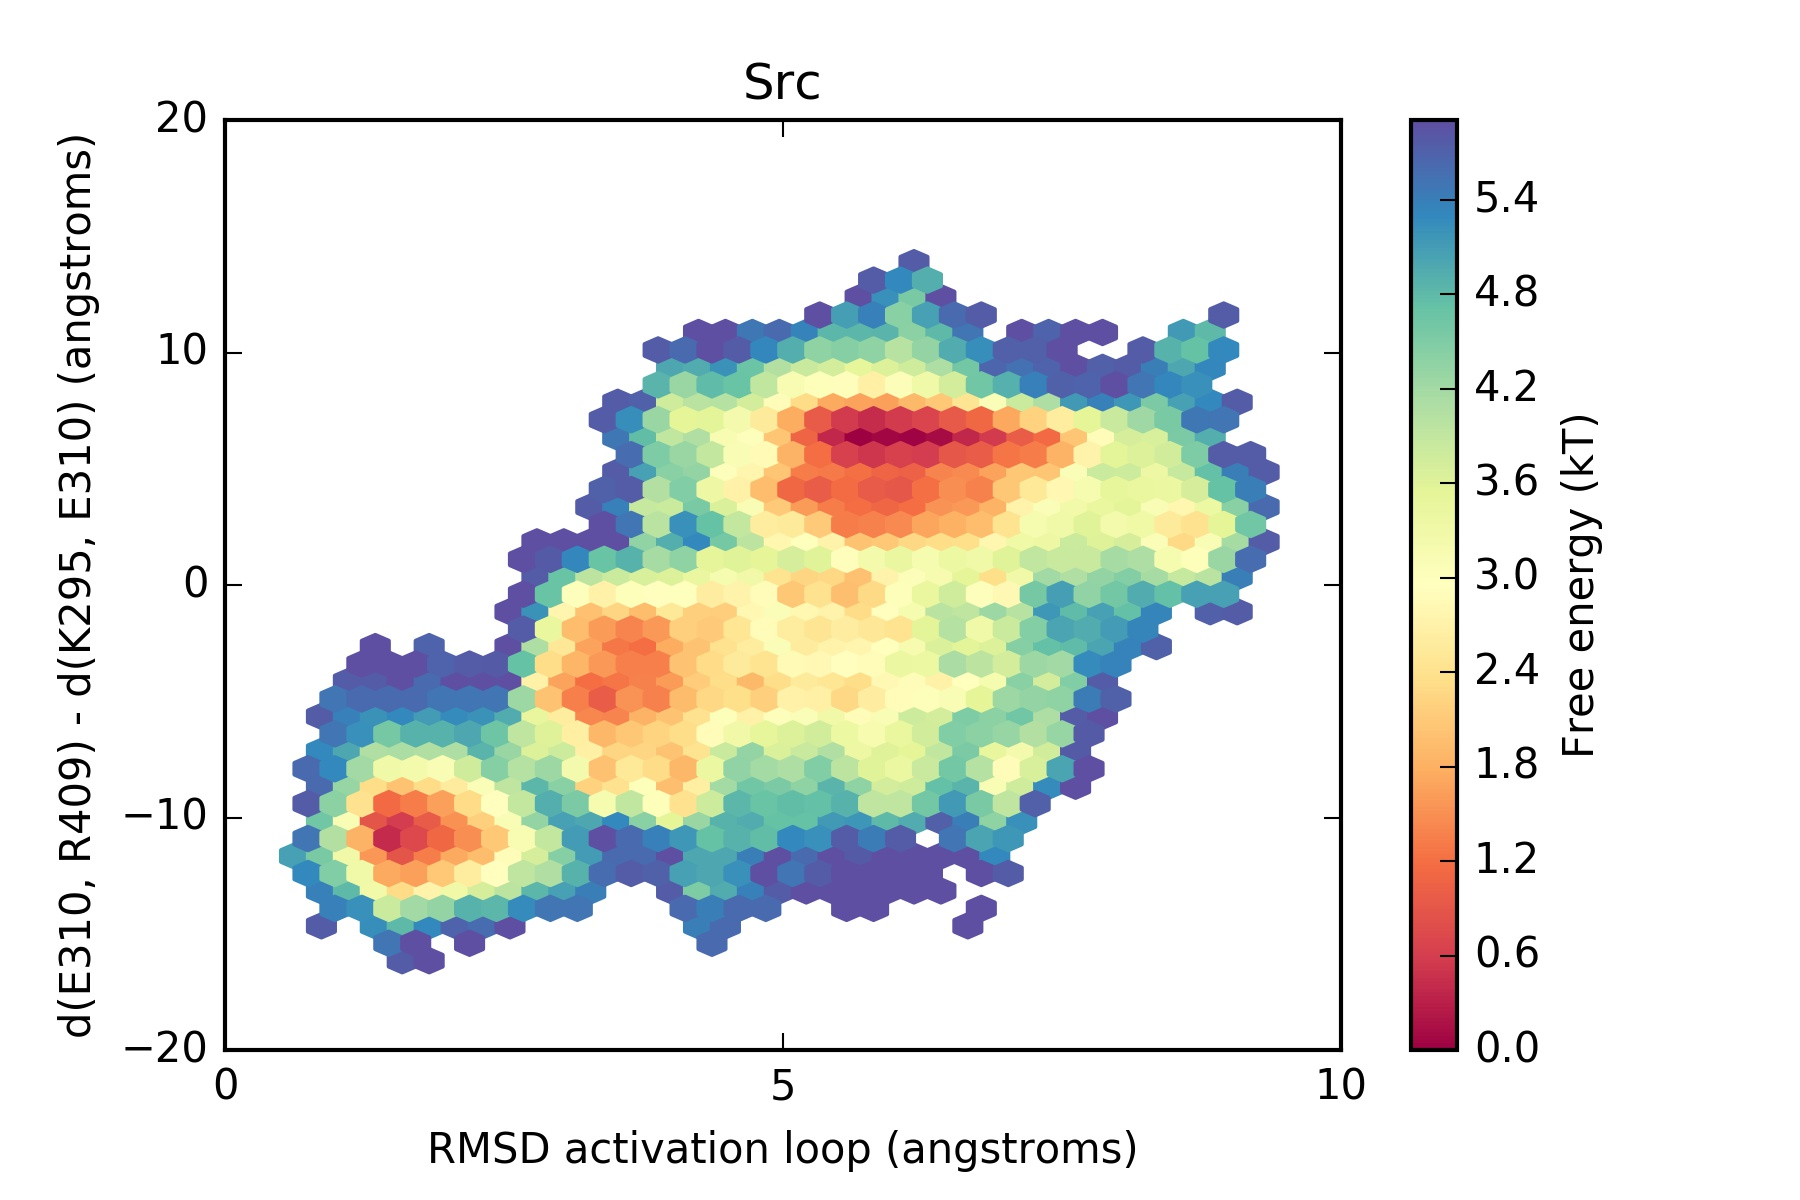

In [253]:
name = 'Src_free_energy_landscape_hex.jpg'
Image(name,retina=True)

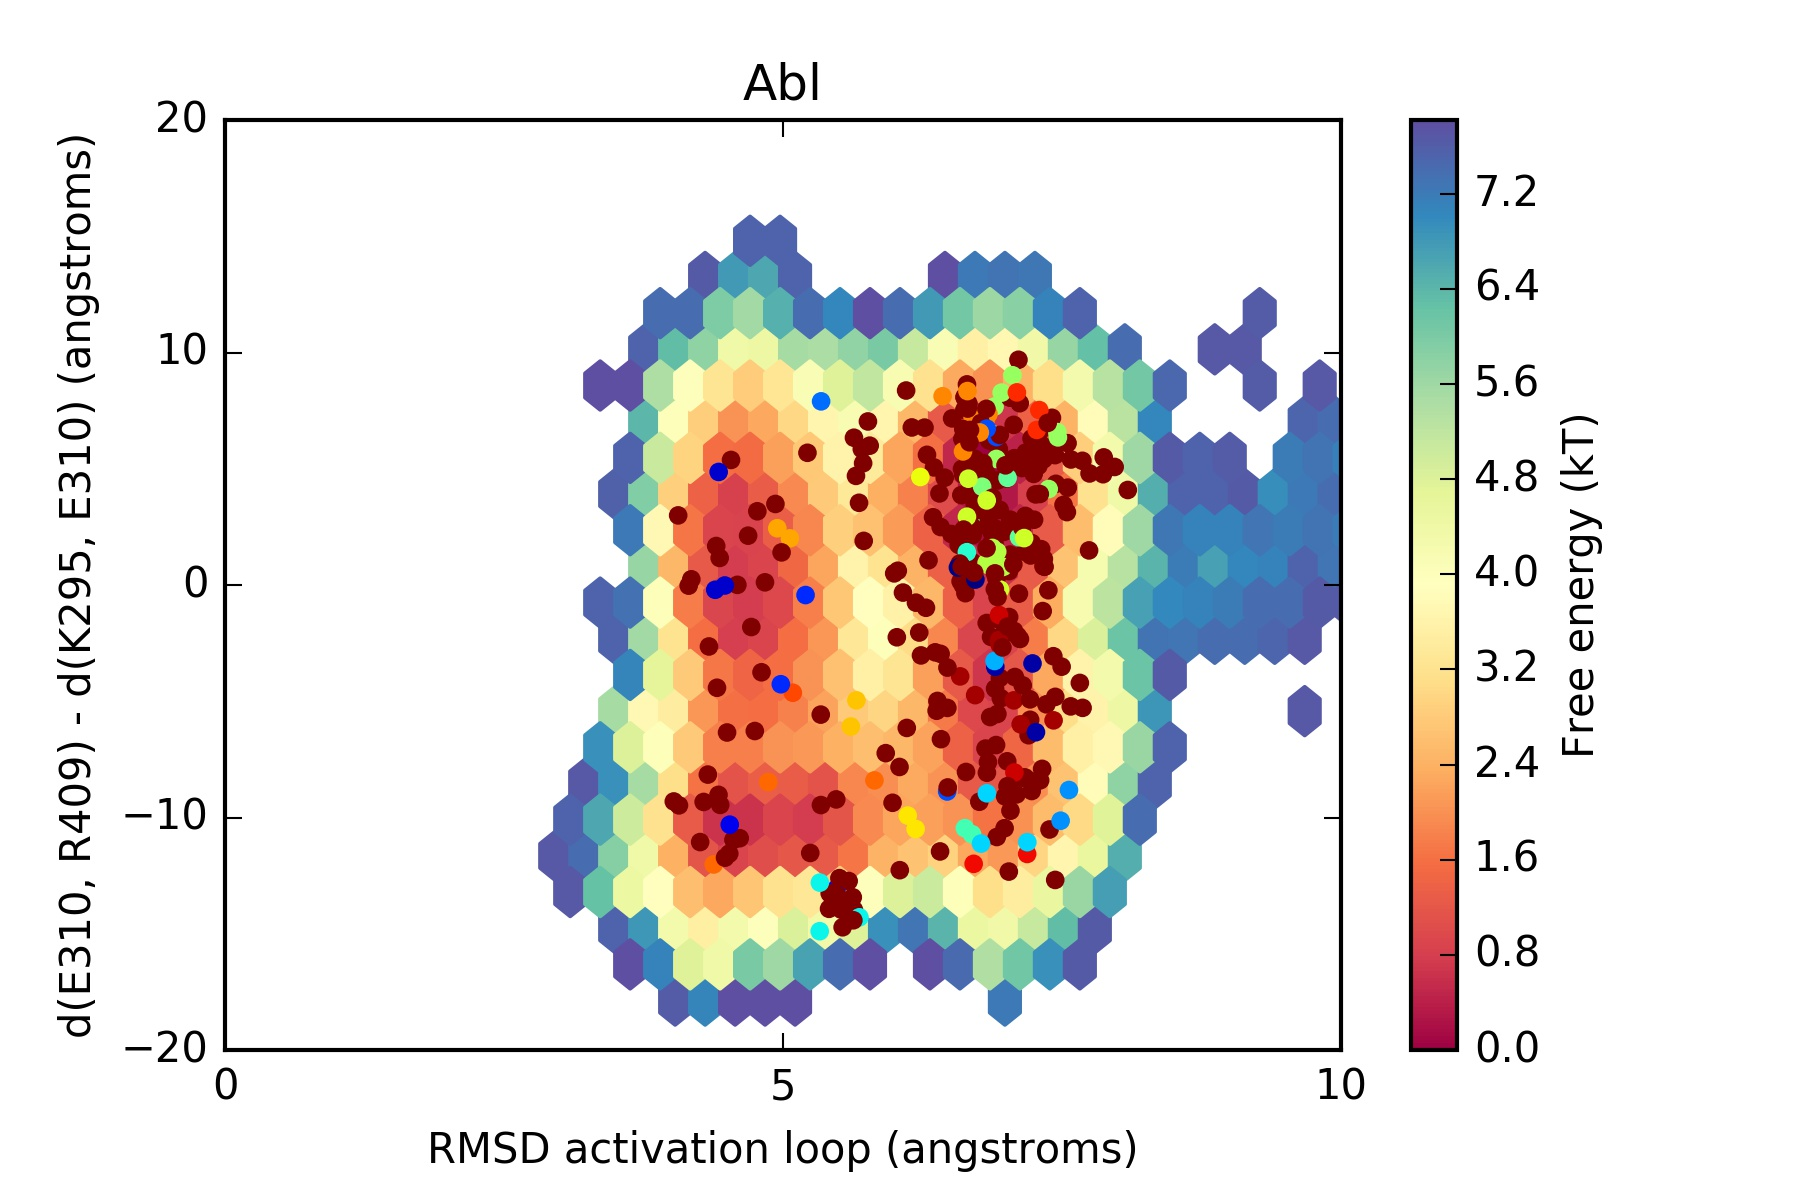

In [252]:
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_abl,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)

plt.scatter(X1[flat_inds_abl][macrostate_ids_abl!=-1],
            X2[flat_inds_abl][macrostate_ids_abl!=-1],
            c=macrostate_ids_abl[macrostate_ids_abl!=-1],
           linewidths=0)

name = 'Abl_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

0
1
2
3
5
6
7
1032
9
10
11
1548
525
14
527
1961
18
19
1558
23
1048
1561
27
1564
29
33
34
548
1030
1574
39
40
1372
43
556
1999
46
1629
51
52
1536
55
568
570
60
1792
575
577
67
1025
1206
1095
1609
951
1100
1963
78
1617
1618
595
526
86
1623
1626
1039
1603
1117
1026
1211
1894
1674
1128
1129
1642
1895
109
110
1555
1896
1650
531
119
1657
122
637
1662
131
1669
1158
1985
136
1673
138
139
140
653
1167
1169
146
1685
1687
152
1476
1692
1694
1184
1188
677
678
168
1930
1991
1196
1709
797
177
1474
1203
1607
694
1207
1209
1722
699
700
1725
1215
704
1218
1855
198
1569
535
201
1899
1229
1741
208
723
1749
1750
216
1753
730
1755
1658
224
1249
1250
891
230
1289
1542
747
1263
240
753
1778
1235
244
1406
246
248
761
1696
1276
765
1278
1279
768
1971
1611
772
1285
1543
1068
1803
1805
782
783
273
1155
789
1974
1688
1918
285
1312
1328
1826
1047
804
805
1830
1320
809
1493
1323
1838
1084
304
1329
1331
1332
1846
1847
1848
313
316
317
830
319
1856
1545
1349
1862
1351
1079
845
1592
338
1251
1364
1365
996
1787
860
195

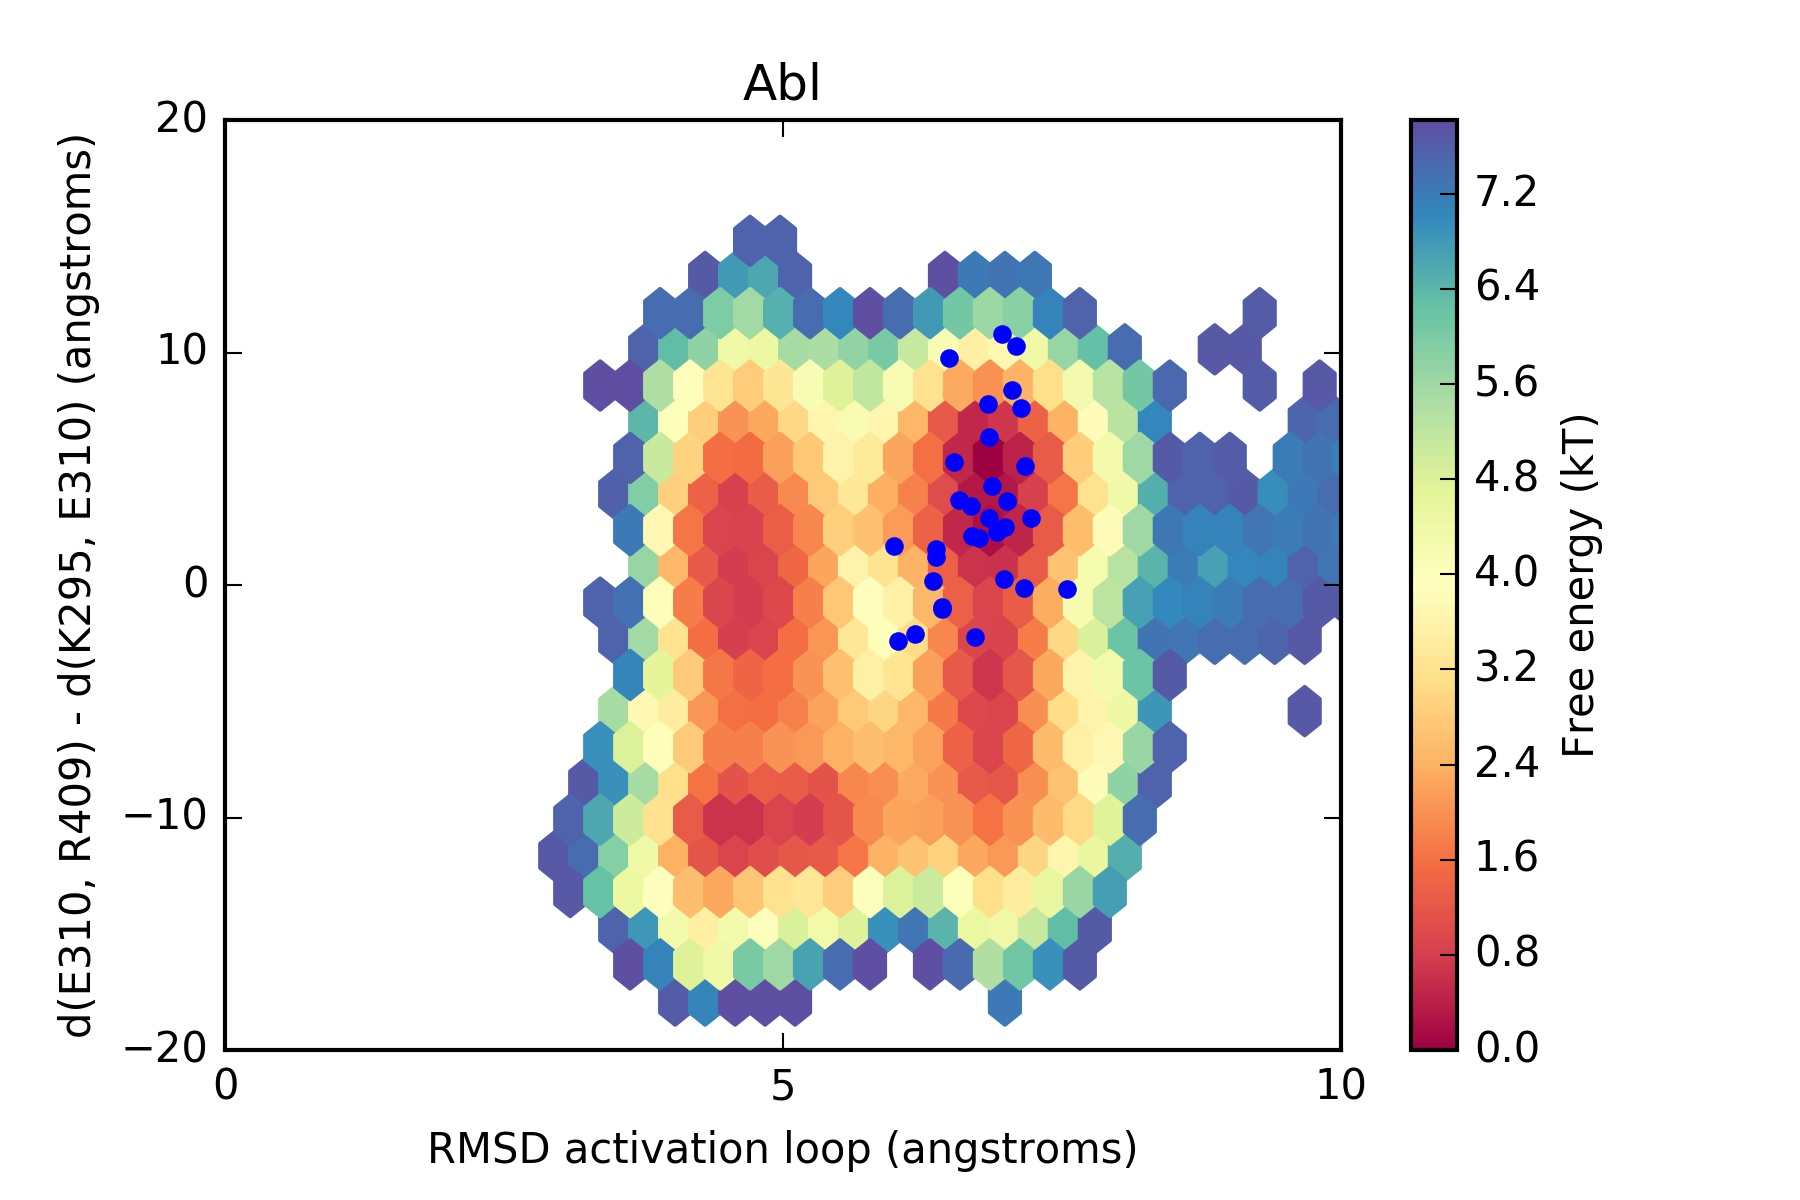

In [277]:
# abl, just one representative per macrostate
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_abl,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)

exemplar_inds_abl = np.load('exemplar_inds_abl.npy')

plt.scatter(X1[exemplar_inds_abl],
            X2[exemplar_inds_abl],
           linewidths=0)

name = 'Abl_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

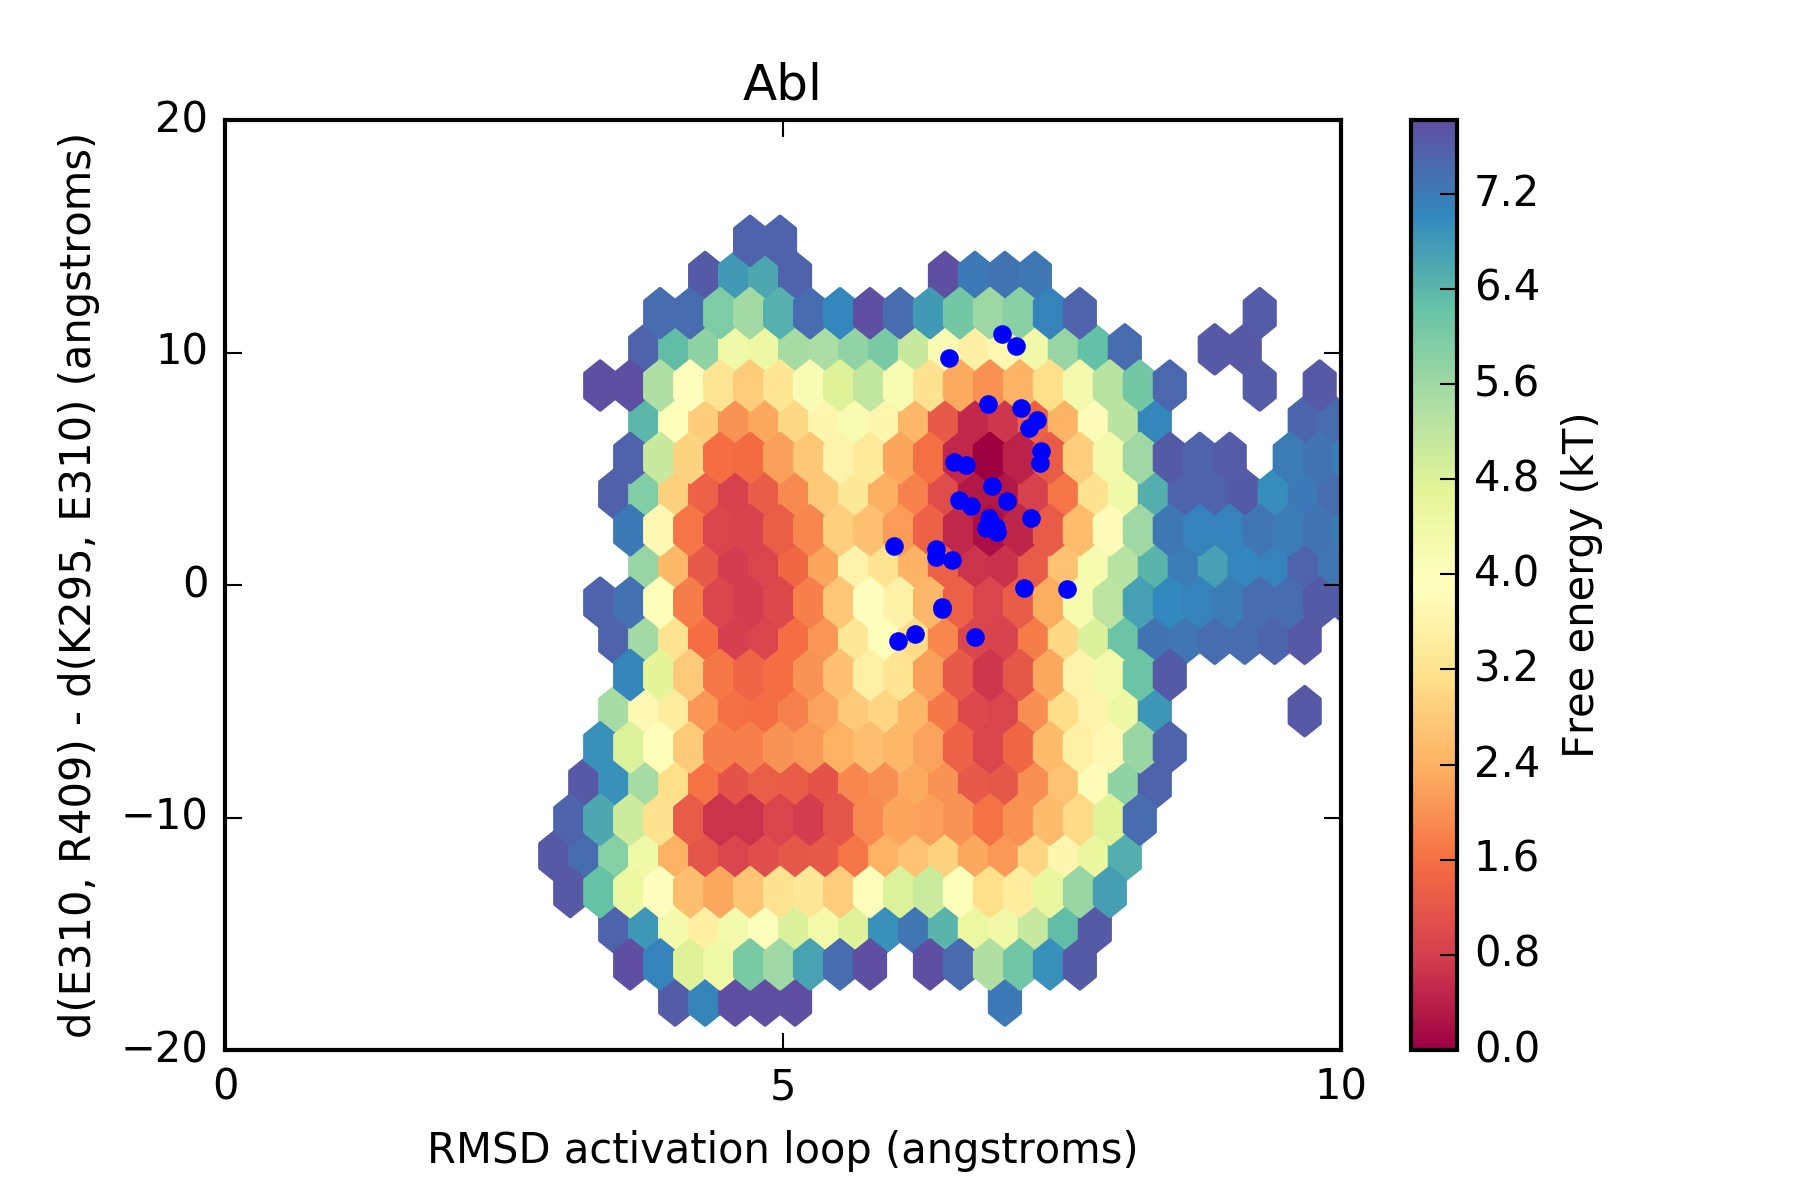

In [280]:
# abl, just one representative per macrostate, given by MCSA 
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_abl,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)

exemplar_inds_abl_mcsa = np.load('mcsa_exemplar_inds_abl.npy')

plt.scatter(X1[exemplar_inds_abl_mcsa],
            X2[exemplar_inds_abl_mcsa],
           linewidths=0)

name = 'Abl_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

In [281]:
sum(exemplar_inds_abl!=exemplar_inds_abl_mcsa)

30

In [285]:
np.array(sorted(exemplar_inds_abl))==np.array(sorted(exemplar_inds_abl_mcsa))

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True], dtype=bool)

In [288]:
overlap = 0
for i in exemplar_inds_abl:
    overlap += (i in exemplar_inds_abl_mcsa)
1.0*overlap/len(exemplar_inds_abl)

0.7419354838709677

In [289]:
overlap

23

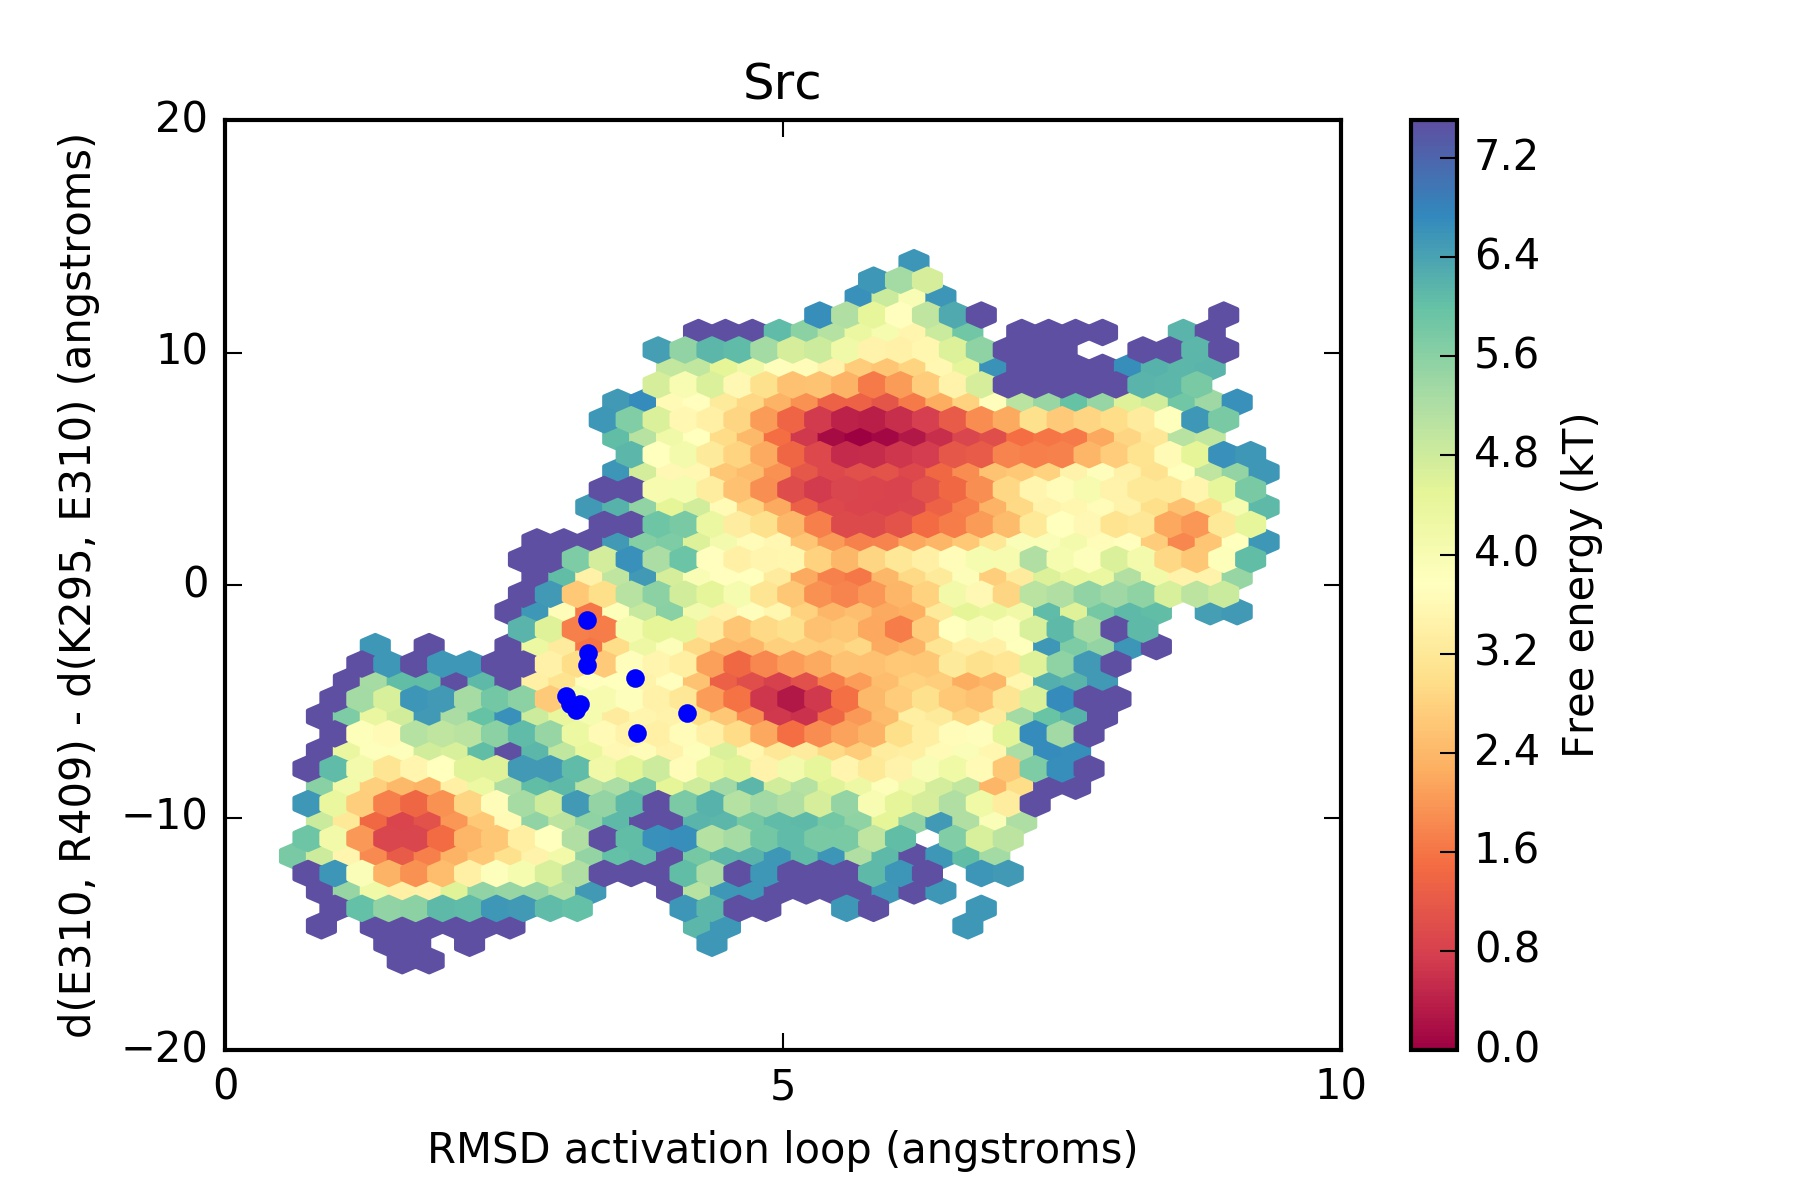

In [257]:
# src, just one representative per macrostate
X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Src',bins=bins)

exemplar_inds_src = np.load('exemplar_inds_src.npy')

plt.scatter(X1[exemplar_inds_src],
            X2[exemplar_inds_src],
           linewidths=0)

name = 'Src_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

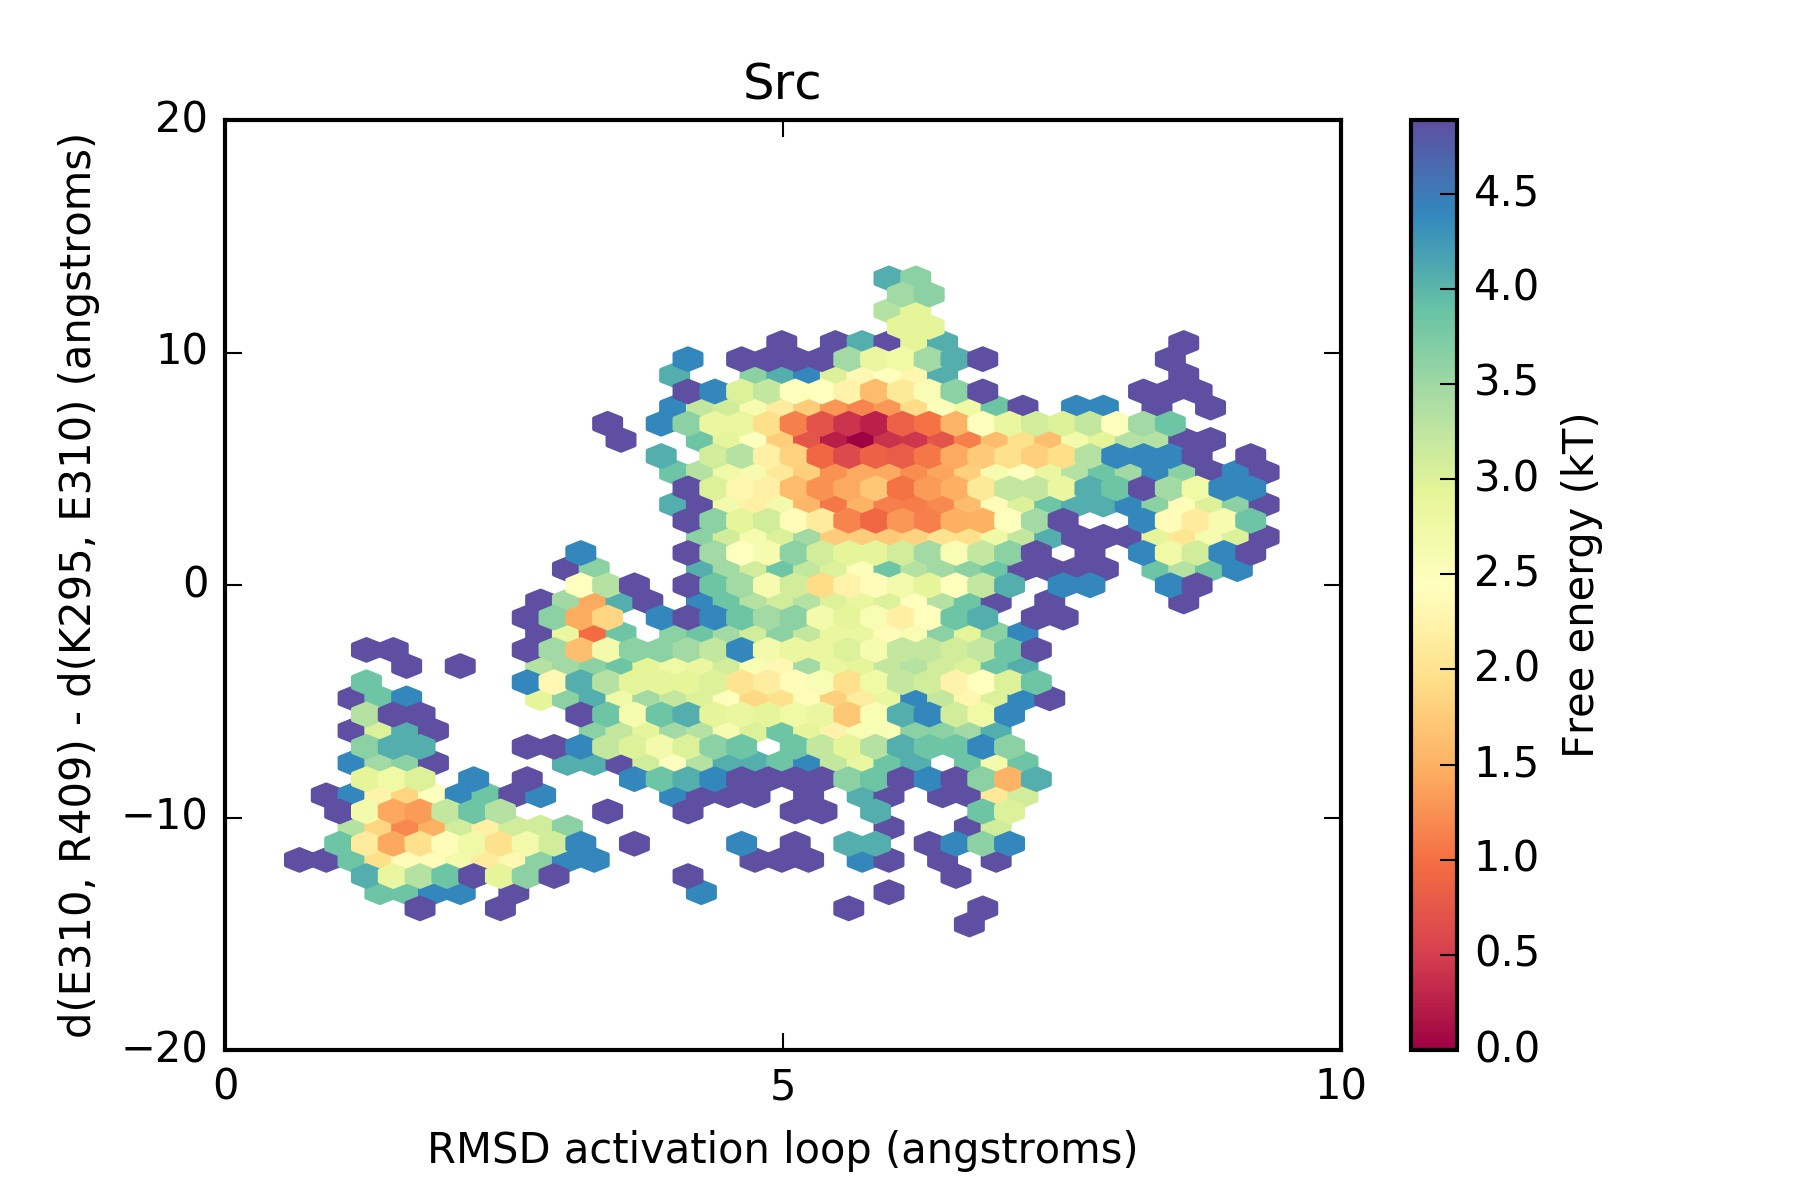

In [259]:
X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

i = 0
shukla_plot_hex(X1[flat_labels==i],X2[flat_labels==i],flat_probs[flat_labels==i],'Src',bins=bins)

#exemplar_inds_src = np.load('exemplar_inds_src.npy')

#plt.scatter(X1[exemplar_inds_src],
#            X2[exemplar_inds_src],
#           linewidths=0)

name = 'Src_free_energy_landscape_hex.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

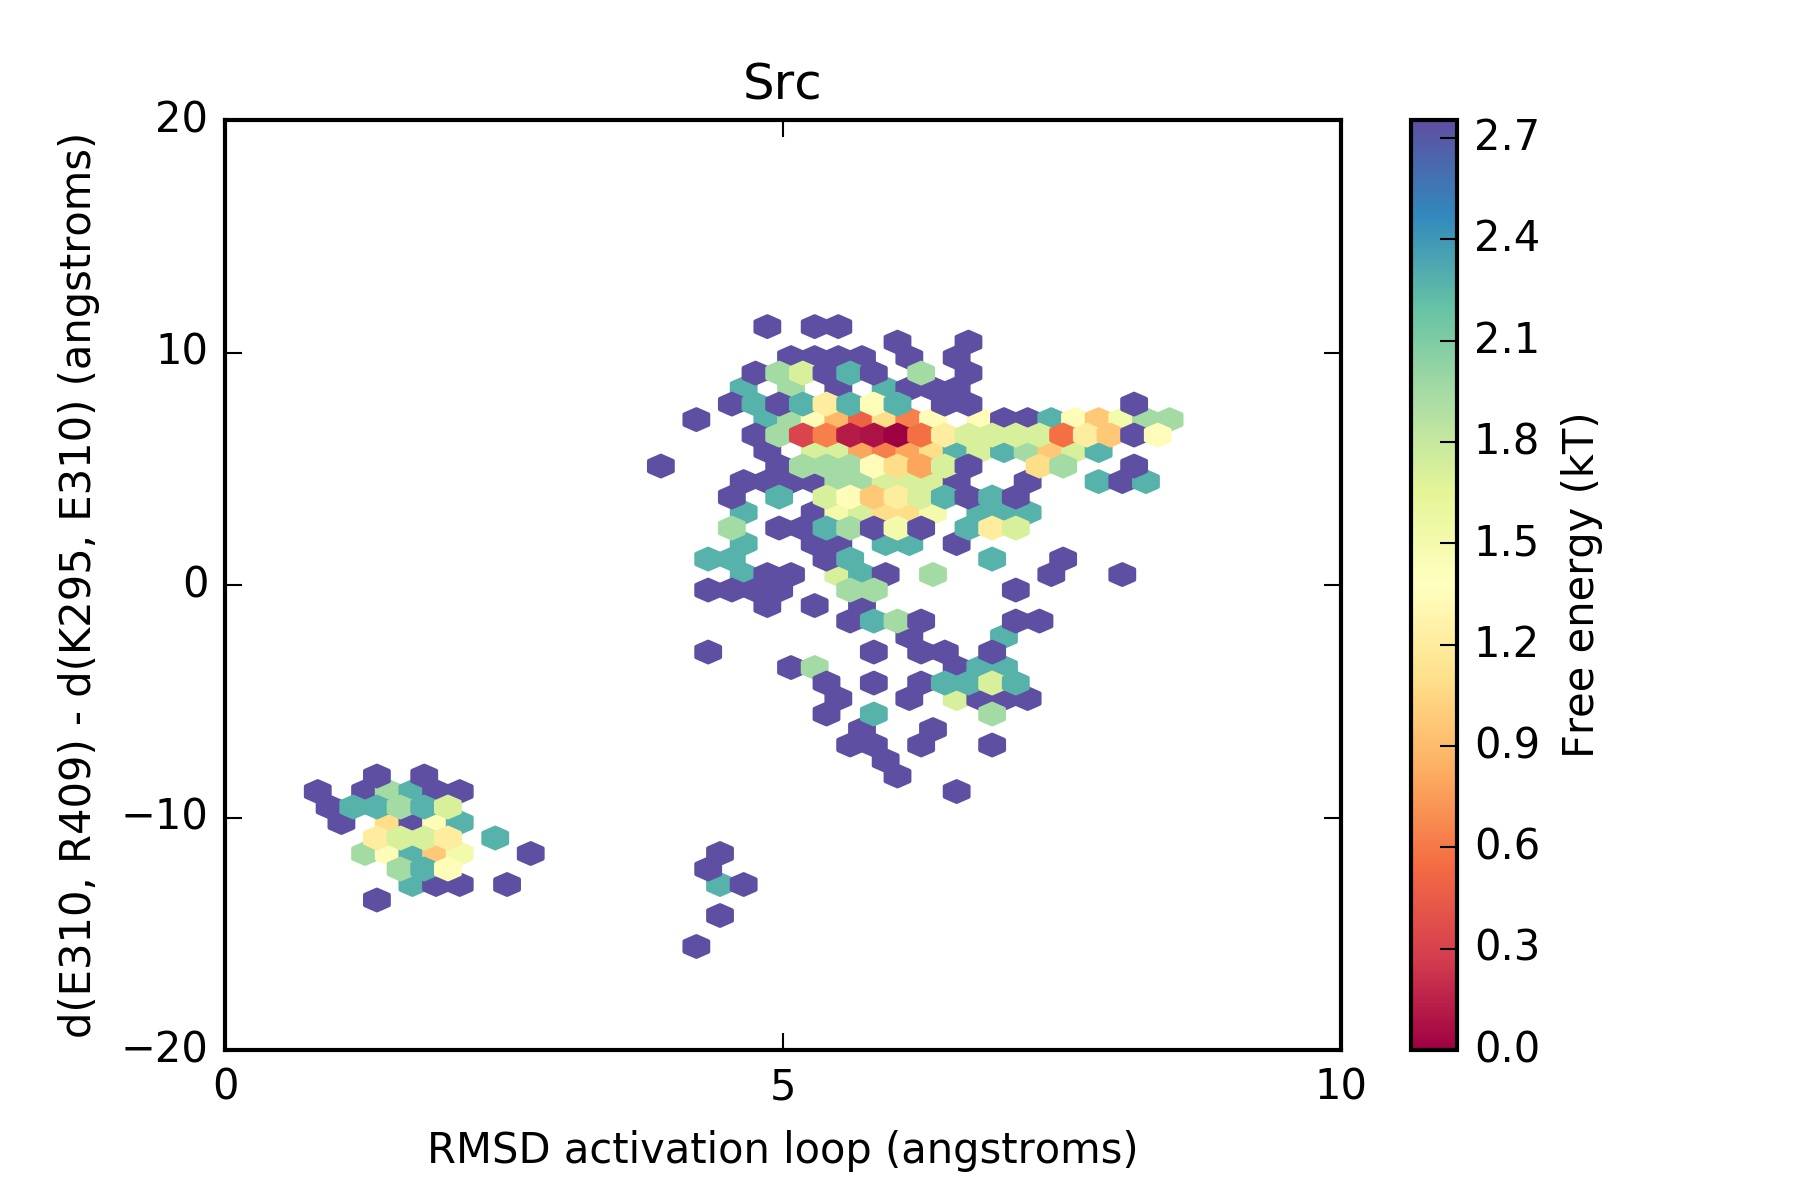

In [266]:
X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

i = 20
shukla_plot_hex(X1[flat_labels==i],X2[flat_labels==i],flat_probs[flat_labels==i],'Src',bins=bins)

#exemplar_inds_src = np.load('exemplar_inds_src.npy')

#plt.scatter(X1[exemplar_inds_src],
#            X2[exemplar_inds_src],
#           linewidths=0)

name = 'Src_free_energy_landscape_hex.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

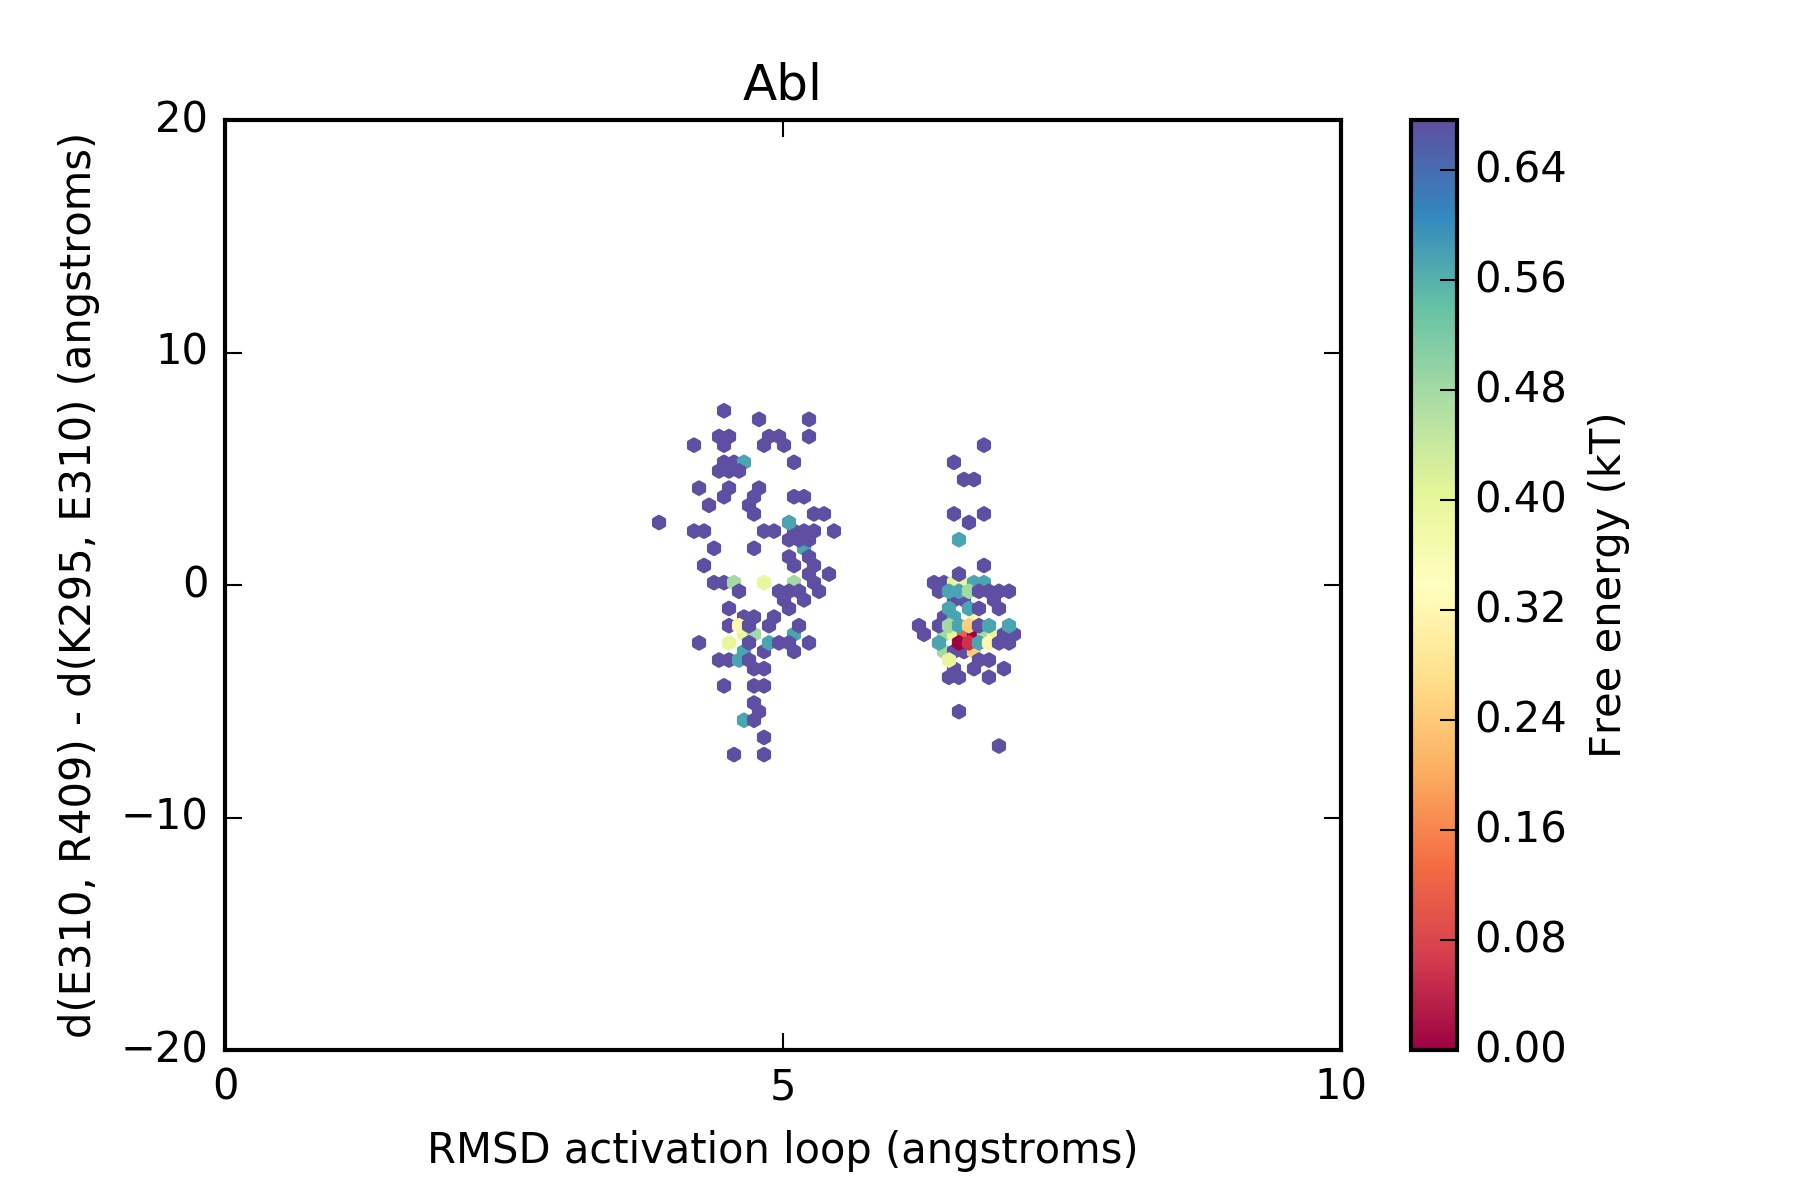

In [274]:
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

bins=36
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_abl,len(set(flat_labels)))

i = 40
shukla_plot_hex(X1[flat_labels==i],X2[flat_labels==i],flat_probs[flat_labels==i],'Abl',bins=bins)

name = 'Abl_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

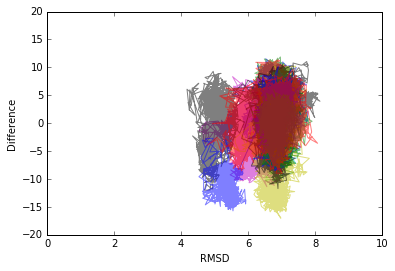

In [328]:
ind = 0
X1 = np.load('rmsd_ABL.npy')
X2 = np.load('difference_ABL.npy')[:,0]

op_trajs = []

for traj in raw_dtrajs_abl[:10]:
    #plt.figure()
    op_trajs.append(np.vstack([X1[ind:ind+len(traj)],X2[ind:ind+len(traj)]]).T)
    
    plt.plot(op_trajs[-1][:,0],op_trajs[-1][:,1],alpha=0.5)
    ind+= len(traj)

    
    plt.ylim(-20,20)
    plt.xlim(0,10)
plt.xlabel('RMSD')
plt.ylabel('Difference')

In [304]:
op_trajs[-1].shape

(7595, 2)

In [307]:
import statsmodels.tsa.stattools
acf = statsmodels.tsa.stattools.acf

I can't visually read off whether the trajectories are rapidly mixing by inspecting this plot, so I also computed the autocorrelation functions of each order parameter (a separate ACF for each trajectory) to see what's going on. (Rapid mixing would show up as a rapid decay to zero.)
http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.tsa.stattools.acf.html

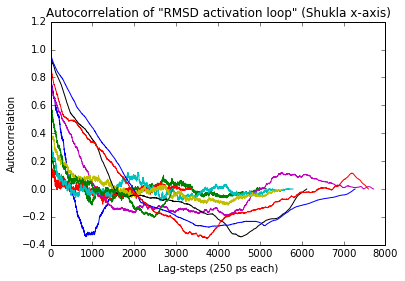

In [326]:
lags=10000
acfs = []
for traj in op_trajs:
    acfs.append(acf(traj[:,0],nlags=lags))
    plt.plot(acfs[-1])
#plt.ylim(0,1)
plt.title('Autocorrelation of "RMSD activation loop" (Shukla x-axis)')
plt.xlabel('Lag-steps (250 ps each)')
plt.ylabel('Autocorrelation')

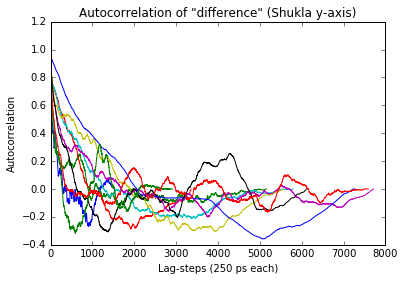

In [329]:
for traj in op_trajs:
    plt.plot(acf(traj[:,1],nlags=lags))
#plt.ylim(0,1)

plt.title('Autocorrelation of "difference" (Shukla y-axis)')
plt.xlabel('Lag-steps (250 ps each)')
plt.ylabel('Autocorrelation')